<h1><center>ICT for Smart Mobility</center></h1>
<h3><center>Laboratory 1 Codes - Team 12</center></h3>

TEAM 12 Cities Assigned to
* New York City
* Hamburg
* Madrid

In [1]:
# import pymongo as pm #import MongoClient only
# from pprint import pprint as pp


# db = client['carsharing'] #Choose the DB to use
# Bookings_collection = db['PermanentBookings'] # Collection for Car2go to use

# # page 50, check count of documents with "city:torino"
# counts = Bookings_collection.count_documents({"city": "Torino"})
# print("total count of docs with city==Torino: ", counts)

# # one_doc = Bookings_collection.find_one({"city": "Torino"})
# # pp(one_doc)


# # one_doc = Bookings_collection.find_one({"city": "Torino", "driving.duration": {"$ne": -1}})
# # pp(one_doc)

# Initial Steps

In [155]:
import pymongo as pm

from pprint import pprint as pp
from datetime import timedelta
import datetime
from collections import Counter
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
# import contextily as ctx

In [2]:
client = pm.MongoClient(
    'bigdatadb.polito.it',
	ssl=True,
	authSource = 'carsharing',
	username = 'ictts',
	password ='Ict4SM22!',
	tlsAllowInvalidCertificates=True
)

# Step 1 - Preliminary Data Analysis

 Collections
Car sharing provider Car2Go:
* "ActiveBookings": Contains cars that are currently booked and not available
* "ActiveParkings": Contains cars that are currently parked and available
* "PermanentBookings": Contains all booking periods recorded so far
* "PermanentParkings": Contains all parking periods recorded so far

Car sharing provider Enjoy:
* "enjoy_ActiveBookings": Contains cars that are currently booked and not available
* "enjoy_ActiveParkings": Contains cars that are currently parked and available
* "enjoy_PermanentBookings": Contains all booking periods recorded so far
* "enjoy_PermanentParkings": Contains all parking periods recorded so far

In [3]:
db = client['carsharing'] #Choose the DB to use

### 1.1.1 How many documents are present in each collection?

In [4]:
collections = [
    "ActiveBookings",
    "ActiveParkings",
    "PermanentBookings",
    "PermanentParkings",
    "enjoy_ActiveBookings",
    "enjoy_ActiveParkings",
    "enjoy_PermanentBookings",
    "enjoy_PermanentParkings"
]

In [5]:
# collection_list = db.list_collections()
# for c in collection_list:
#     print(c)

In [6]:
for collection in collections:
    col = db[collection]
    print(f"In collection '{collection}' There are {col.count_documents({})} documents.")

In collection 'ActiveBookings' There are 8743 documents.
In collection 'ActiveParkings' There are 4790 documents.
In collection 'PermanentBookings' There are 28180508 documents.
In collection 'PermanentParkings' There are 28312676 documents.
In collection 'enjoy_ActiveBookings' There are 0 documents.
In collection 'enjoy_ActiveParkings' There are 0 documents.
In collection 'enjoy_PermanentBookings' There are 6653472 documents.
In collection 'enjoy_PermanentParkings' There are 6689979 documents.


### 1.1.2 Why the number of documents in PermanentParkings and PermanentBooking is similar?

Booking represents the "disapearance" of a car and Parking represents "reappearance" of a car. Since the total number of cars are fairly fixed and time to time a car can totally go out of service (disappear for any reason), the number of "Permanenet Bookings" may appear a little less than the "Permanenet Parkings".

### 1.1.3 For which cities the system is collecting data?

In [12]:
for collection in collections:
    col = db[collection]
    unique_cities = col.distinct('city')
    print(f"Cities in collection '{collection}':")
    print(unique_cities)
    print("\n")

Cities in collection 'ActiveBookings':
['Amsterdam', 'Austin', 'Berlin', 'Calgary', 'Columbus', 'Denver', 'Firenze', 'Frankfurt', 'Hamburg', 'Madrid', 'Milano', 'Montreal', 'Munchen', 'New York City', 'Portland', 'Rheinland', 'Roma', 'Seattle', 'Stuttgart', 'Torino', 'Toronto', 'Vancouver', 'Washington DC', 'Wien']


Cities in collection 'ActiveParkings':
['Austin', 'Columbus', 'Denver', 'Firenze', 'Hamburg', 'Madrid', 'Munchen', 'Seattle', 'Torino', 'Toronto', 'Vancouver', 'Washington DC', 'Wien']


Cities in collection 'PermanentBookings':
['Wien', 'Washington DC', 'Vancouver', 'Twin Cities', 'Toronto', 'Torino', 'Stuttgart', 'Seattle', 'San Diego', 'Roma', 'Rheinland', 'Portland', 'New York City', 'Munchen', 'Montreal', 'Milano', 'Madrid', 'Hamburg', 'Frankfurt', 'Firenze', 'Denver', 'Columbus', 'Calgary', 'Berlin', 'Austin', 'Amsterdam']


Cities in collection 'PermanentParkings':
['Amsterdam', 'Austin', 'Berlin', 'Calgary', 'Columbus', 'Denver', 'Firenze', 'Frankfurt', 'Hamburg', 

### 1.1.4 When did each collection start? When did each collection end?

There are "init_time"/"init_date" and "final_time"/"final_date" in each document of collections. We can see the range of this key/field.

In [13]:
collection_init_final_min_max = {}

for collection in collections:
    print(f"computing min/max time for '{collection}'...")
    col = db[collection]
    
    distinct_init_time_arry = np.array(col.distinct("init_time"))
    distinct_final_time_arry = np.array(col.distinct("final_time"))
    
    if len(distinct_init_time_arry) > 0:
        min_init_time = np.min(distinct_init_time_arry)
        # max_init_time = np.max(distinct_init_time_arry)
    if len(distinct_final_time_arry) > 0:
        # min_final_time = np.min(distinct_final_time_arry)
        max_final_time = np.max(distinct_final_time_arry)
        
    init_final_min_max = {
        "init_min": min_init_time,
        # "init_max": max_init_time,
        # "final_min": min_final_time,
        "final_max": max_final_time
    }
    
    collection_init_final_min_max[collection] = init_final_min_max

computing min/max time for 'ActiveBookings'...
computing min/max time for 'ActiveParkings'...
computing min/max time for 'PermanentBookings'...
computing min/max time for 'PermanentParkings'...
computing min/max time for 'enjoy_ActiveBookings'...
computing min/max time for 'enjoy_ActiveParkings'...
computing min/max time for 'enjoy_PermanentBookings'...
computing min/max time for 'enjoy_PermanentParkings'...


In [14]:
collection_init_final_min_max

{'ActiveBookings': {'init_min': 1512999938, 'final_max': -1},
 'ActiveParkings': {'init_min': 1516773360, 'final_max': -1},
 'PermanentBookings': {'init_min': 1481650703, 'final_max': 1517404383},
 'PermanentParkings': {'init_min': 1481650658, 'final_max': 1517404383},
 'enjoy_ActiveBookings': {'init_min': 1481650658, 'final_max': 1517404383},
 'enjoy_ActiveParkings': {'init_min': 1481650658, 'final_max': 1517404383},
 'enjoy_PermanentBookings': {'init_min': 1493996781, 'final_max': 1560187235},
 'enjoy_PermanentParkings': {'init_min': 1493996736, 'final_max': 1560187235}}

The value "-1" could mean the trip is ongoing and there is not final time.

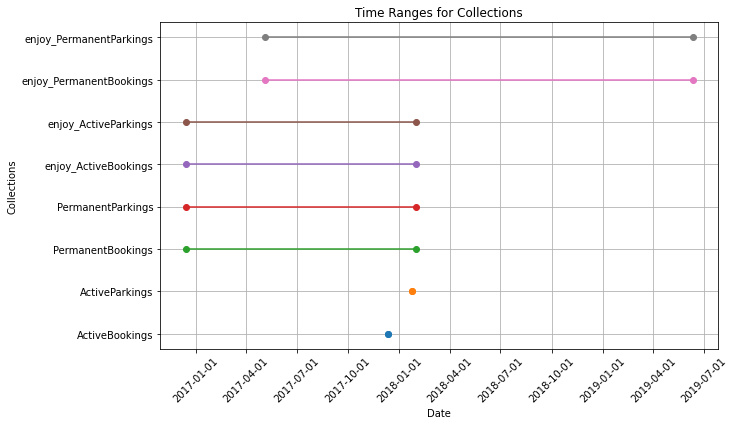

In [56]:
time_data = collection_init_final_min_max

collections = []
start_times = []
end_times = []
current_time = datetime.datetime.now()

for collection, times in time_data.items():
    # convert uinx to datetime
    init_min = datetime.datetime.fromtimestamp(times['init_min'])
    final_max = datetime.datetime.fromtimestamp(times['final_max']) if times['final_max'] != -1 else init_min

    collections.append(collection)
    start_times.append(init_min)
    end_times.append(final_max)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot range for each category
for i, collection in enumerate(collections):
    ax.plot([start_times[i], end_times[i]], [collection, collection], marker='o', label=collection)

# Formatting the plot
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Collections")
plt.title("Time Ranges for Collections")
plt.grid()
plt.show()

### 1.1.5 What about the timezone of the init_date and init_time timestamps? Which timezone do they refer to?

In [18]:
example_doc = db["PermanentBookings"].find_one()
example_init_date = example_doc["init_date"]
example_init_time = example_doc["init_time"]

In [19]:
print(f"Example init time '{example_init_time}' and example init date '{example_init_date}' to explore the timezone...")

Example init time '1481650703' and example init date '2016-12-13 09:38:23' to explore the timezone...


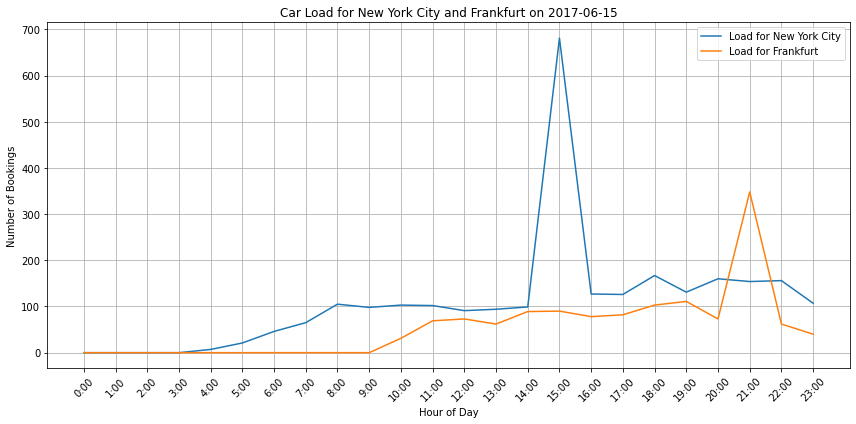

In [20]:
# Define date and cities for analysis
selected_date = datetime.datetime(2017, 6, 15)
next_day = selected_date + datetime.timedelta(days=1)
cities = ["New York City", "Frankfurt"]  # Example cities to analyze

# Query PermanentBookings collection for the selected day
data = {}
for city in cities:
    bookings = list(db["PermanentBookings"].find({
        "init_date": {"$gte": selected_date, "$lt": next_day},
        "city": city
    }))
    data[city] = bookings

# Process data to count bookings by time interval
time_intervals = [datetime.timedelta(hours=i) for i in range(24)]
time_labels = [f"{i}:00" for i in range(24)]
load_data = {city: [0] * 24 for city in cities}

for city in cities:
    for booking in data[city]:
        hour = booking["init_date"].hour
        load_data[city][hour] += 1  # Increment the load for that hour

plt.figure(figsize=(12, 6))
for city in cities:
    plt.plot(time_labels, load_data[city], label=f"Load for {city}")

plt.xlabel("Hour of Day")
plt.ylabel("Number of Bookings")
plt.title(f"Car Load for {cities[0]} and {cities[1]} on {selected_date.strftime('%Y-%m-%d')}")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The "init_time" and "init_date" does not show any timezone in them.
In this plot we see a random days load of cars during the day for two cities, New York City and Frankfurt, which are actually 5 hours appart from each other in terms of times zone.
There are one sharp peak for each of these cities which are almost 5 hours appart and it indicates the peaks for a specific time in the cities. It can show that the timezone is not considered for storing the data and they are some UTC timezone.
* Frankfurt, Germany is 5 hours ahead of New York, NY, USA

## Considering the three cities assigned to your group.
* New York City
* Hamburg
* Madrid

In [21]:
cities = ["New York City", "Hamburg", "Madrid"]

### 1.2.1 What is the total number of cars seen in the whole period in each city? How can you estimate the fleet size in a given period, e.g., one week? How does this relate to the total number of vehicles seen in the whole collection?

* Since we only have the cities in the Car2Go data for these cities we only use these collections and drop the Enjoy collections...
* Also every other documents will be present in the "PermanentParkings" so we can explore for this collections for the questions...

In [22]:
collection = db["PermanentParkings"]

#### What is the total number of cars seen in the whole period in each city?

In [23]:
car_counts = {}
for city in cities:
    car_counts[city] = collection.distinct("vin", {"city": city})

total_cars_seen = {city: len(vins) for city, vins in car_counts.items()}
print("Total number of unique cars seen in each city:", total_cars_seen)

Total number of unique cars seen in each city: {'New York City': 968, 'Hamburg': 1012, 'Madrid': 475}


#### How can you estimate the fleet size in a given period, e.g., one week?

In [24]:
start_date = datetime.datetime(2017, 7, 1)
end_date = start_date + timedelta(days=7)

weekly_fleet_size = {}

for city in cities:
    weekly_fleet_size[city] = len(collection.distinct("vin", {
        "city": city,
        "init_date": {"$gte": start_date, "$lt": end_date}
    }))

print("Estimated fleet size over one week for each city:", weekly_fleet_size)

Estimated fleet size over one week for each city: {'New York City': 506, 'Hamburg': 785, 'Madrid': 451}


#### How does this relate to the total number of vehicles seen in the whole collection?

In [25]:
fleet_ratio = {city: (weekly_fleet_size[city] / total_cars_seen[city]) * 100
               if total_cars_seen[city] > 0 else 0
               for city in cities}

print("Ratio of weekly fleet size to total fleet size for each city:", fleet_ratio)

Ratio of weekly fleet size to total fleet size for each city: {'New York City': 52.27272727272727, 'Hamburg': 77.5691699604743, 'Madrid': 94.94736842105263}


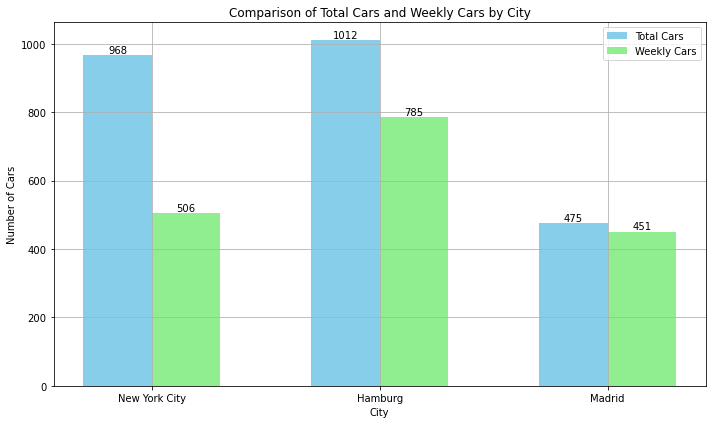

In [26]:
total_cars = list(total_cars_seen.values())
weekly_cars = list(weekly_fleet_size.values())

x = np.arange(len(cities))
width = 0.3  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

bars_total = ax.bar(x - width/2, total_cars, width, label='Total Cars', color='skyblue')
bars_weekly = ax.bar(x + width/2, weekly_cars, width, label='Weekly Cars', color='lightgreen')

ax.set_xlabel("City")
ax.set_ylabel("Number of Cars")
ax.set_title("Comparison of Total Cars and Weekly Cars by City")
ax.set_xticks(x)
ax.set_xticklabels(cities)
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

add_labels(bars_total)
add_labels(bars_weekly)

plt.tight_layout()
plt.grid()
plt.show()

In a city like New York City the difference between the weekly number of cars and total number of cars are large. This can be due to the fact that cars go out of the system and new cars replaced to serve the cosumters while this is not the case of a city like Madrid. In Madrid the total number of cars and weekly number of the cars are faily similar which shows that through out the time, the cars don't much get replaced and they stay in the car sharing system.

### 1.2.2 How many bookings have been recorded in December 2017 in each city?

In [28]:
collection = db["PermanentBookings"]

start_date = datetime.datetime(2017, 12, 1)
end_date = datetime.datetime(2018, 1, 1)

december_bookings = {}

for city in cities:
    december_bookings[city] = collection.count_documents({
        "city": city,
        "init_date": {"$gte": start_date, "$lt": end_date}
    })

print("Number of bookings in December 2017 for each city:", december_bookings)

Number of bookings in December 2017 for each city: {'New York City': 74957, 'Hamburg': 257019, 'Madrid': 171057}


### 1.2.3 How many bookings have the alternative transportation modes recorded in each city?

Considering the cities found in 1.1.3 we can do the analysis:

In [29]:
collection = db["PermanentBookings"]
cities = ['Wien', 'Washington DC', 'Vancouver', 'Twin Cities', 'Toronto', 'Torino', 'Stuttgart', 'Seattle', 
          'San Diego', 'Roma', 'Rheinland', 'Portland', 'New York City', 'Munchen', 'Montreal', 'Milano', 
          'Madrid', 'Hamburg', 'Frankfurt', 'Firenze', 'Denver', 'Columbus', 'Calgary', 'Berlin', 'Austin', 'Amsterdam']

alternative_mode_counts = {}

for city in cities:
    alternative_mode_counts[city] = collection.count_documents({
        "city": city,
        "walking.duration": {"$gt": -1},
        "walking.distance": {"$gt": -1},
        "driving.duration": {"$gt": -1},
        "driving.distance": {"$gt": -1}
    })

print("Bookings with alternative transportation modes recorded in each city:", alternative_mode_counts)

Bookings with alternative transportation modes recorded in each city: {'Wien': 0, 'Washington DC': 0, 'Vancouver': 0, 'Twin Cities': 0, 'Toronto': 0, 'Torino': 296398, 'Stuttgart': 0, 'Seattle': 0, 'San Diego': 0, 'Roma': 0, 'Rheinland': 0, 'Portland': 0, 'New York City': 0, 'Munchen': 0, 'Montreal': 0, 'Milano': 727059, 'Madrid': 0, 'Hamburg': 0, 'Frankfurt': 0, 'Firenze': 0, 'Denver': 0, 'Columbus': 0, 'Calgary': 0, 'Berlin': 0, 'Austin': 0, 'Amsterdam': 0}


Only "Torino" and "Milano" has alternative modes of transportation and others don't have the data in the collection

# Step 2 - Car Sharing Usage Characterization

### 2.1 Booking and Parking durations CDF

In [30]:
bookings = db["PermanentBookings"]
parkings = db["PermanentParkings"]

# Define the cities and time period
cities = ["New York City", "Hamburg", "Madrid"]
start_date = datetime.datetime(2017, 11, 1)
end_date = datetime.datetime(2018, 1, 31)

# Function to retrieve durations in batches
def get_durations_in_batches(collection, cities, start_date, end_date, batch_size=10000):
    durations = {city: [] for city in cities}
    
    for city in cities:
        cursor = collection.find({
            "city": city,
            "init_date": {"$gte": start_date, "$lt": end_date},
            "final_date": {"$gte": start_date, "$lt": end_date}
        }, {"init_date": 1, "final_date": 1}).batch_size(batch_size)
        
        for doc in cursor:
            duration = (doc["final_date"] - doc["init_date"]).total_seconds() / 60  # in minutes
            durations[city].append(duration)
    
    return durations

# Retrieve booking and parking durations in batches
booking_durations = get_durations_in_batches(bookings, cities, start_date, end_date)
parking_durations = get_durations_in_batches(parkings, cities, start_date, end_date)

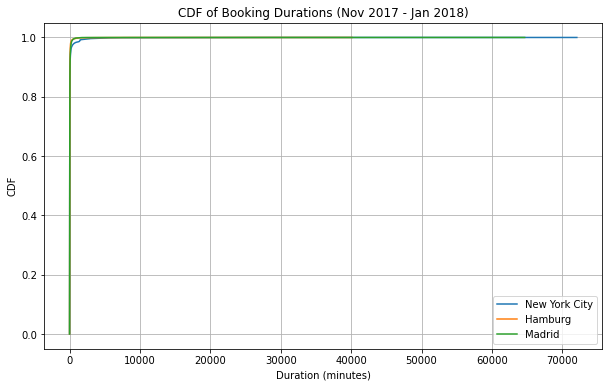

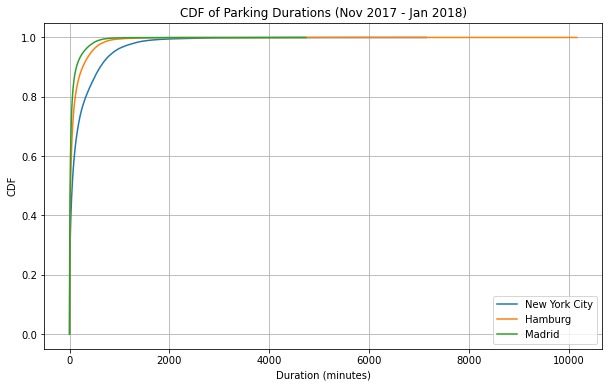

In [31]:
def plot_cdf(data, title):
    plt.figure(figsize=(10, 6))
    for city, durations in data.items():
        if durations:  # Only plot if there is data
            durations_sorted = np.sort(durations)
            cdf = np.arange(len(durations_sorted)) / float(len(durations_sorted))
            plt.plot(durations_sorted, cdf, label=city)
    plt.title(title)
    plt.xlabel("Duration (minutes)")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid()
    plt.show()

plot_cdf(booking_durations, "CDF of Booking Durations (Nov 2017 - Jan 2018)")
plot_cdf(parking_durations, "CDF of Parking Durations (Nov 2017 - Jan 2018)")

The results show some strange behaviour. There are trips/cars with duration of large values in terms of minutes. It seems that the a trip time of larger than 3 hours seems unreasonable and could be due to some problem. We can explore the CDF of trips less than 3 hours to see the result...

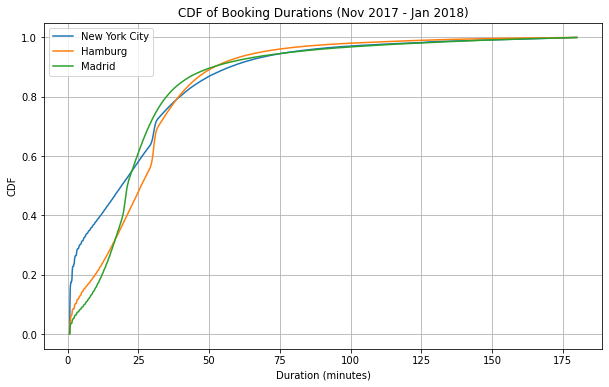

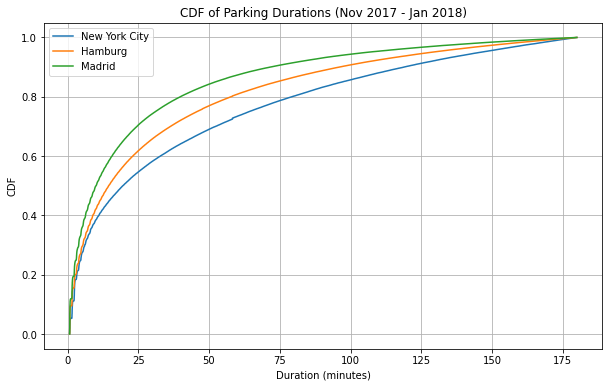

In [32]:
def plot_cdf(data, title):
    plt.figure(figsize=(10, 6))
    for city, durations in data.items():
        if durations:  # Only plot if there is data
            durations_sorted = np.sort([d for d in durations if d<180])
            cdf = np.arange(len(durations_sorted)) / float(len(durations_sorted))
            plt.plot(durations_sorted, cdf, label=city)
    plt.title(title)
    plt.xlabel("Duration (minutes)")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid()
    plt.show()

# Plot CDF for overall booking and parking durations
plot_cdf(booking_durations, "CDF of Booking Durations (Nov 2017 - Jan 2018)")
plot_cdf(parking_durations, "CDF of Parking Durations (Nov 2017 - Jan 2018)")

Now it seems more reasonable...

#### 2.1.a Which city has more density for larger values of duration? Is this expected? Does the CDF suggest the presence of some outliers?

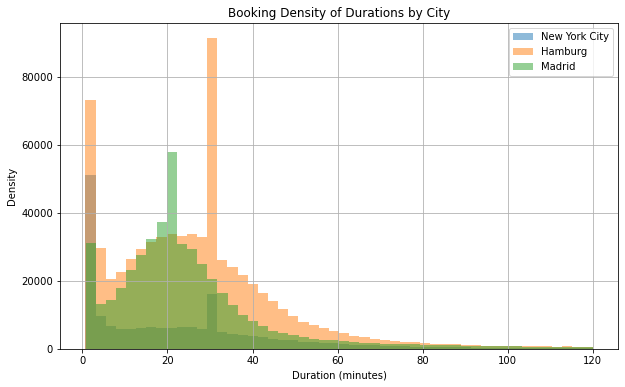

In [33]:
plt.figure(figsize=(10, 6))

for city, durations in booking_durations.items():
    plt.hist(
        [d for d in durations if d < 120], 
        bins=50, 
        alpha=0.5,
        label=city
    )

plt.title("Booking Density of Durations by City")
plt.xlabel("Duration (minutes)")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

It seems that the density of larger durations are more present in a city like Hamburg. We already knew there might be some outlier present from the initial CDF so we mitigated them in previous stage. The density seems more normal after filtering the outliers.

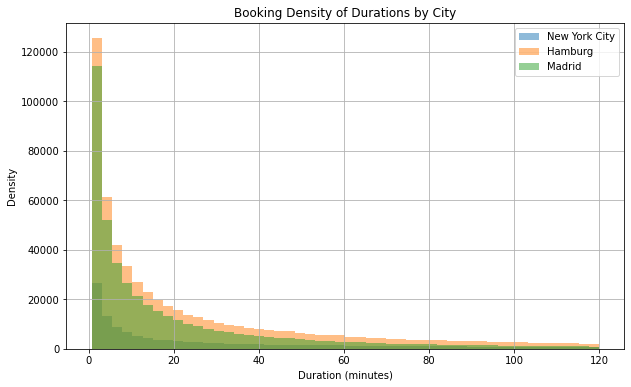

In [57]:
plt.figure(figsize=(10, 6))

for city, durations in parking_durations.items():
    plt.hist(
        [d for d in durations if d < 120], 
        bins=50, 
        alpha=0.5,
        label=city
    )

plt.title("Booking Density of Durations by City")
plt.xlabel("Duration (minutes)")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

#### 2.1.b How do you interpret the differences in the CDFs?

Differnt shapes of CDFs for each city can be considered a characteristic for that city of how users use the car sharing service or maybe this can be a characteristic of how the routs and trips are generally distributed in that city. For example in a city like New York City there are less long trips and can mean many trips are of short duration while in Hamburg people tend to book the car for a longer duration trip.

#### 2.1.c Does the CDF change over time? E.g., aggregate per different weeks of data, or per different days. Are these CDFs different? Why?

In [34]:
cities = ["New York City", "Hamburg", "Madrid"]
start_date = datetime.datetime(2017, 11, 1)
end_date = datetime.datetime(2018, 1, 31)

# Function to retrieve durations by week
def get_weekly_durations(collection, cities, start_date, end_date, batch_size=10000):
    weekly_durations = {city: {} for city in cities}
    
    for city in cities:
        cursor = collection.find({
            "city": city,
            "init_date": {"$gte": start_date, "$lt": end_date},
            "final_date": {"$gte": start_date, "$lt": end_date}
        }, {"init_date": 1, "final_date": 1}).batch_size(batch_size)
        
        for doc in cursor:
            init_date = doc["init_date"]
            week = init_date.strftime("%Y-%U")  # Year-Week format to group by week
            duration = (doc["final_date"] - init_date).total_seconds() / 60  # duration in minutes
            
            # Initialize weekly list if it doesn't exist
            if week not in weekly_durations[city]:
                weekly_durations[city][week] = []
            weekly_durations[city][week].append(duration)
    
    return weekly_durations

# Retrieve weekly booking and parking durations
weekly_booking_durations = get_weekly_durations(bookings, cities, start_date, end_date)
weekly_parking_durations = get_weekly_durations(parkings, cities, start_date, end_date)

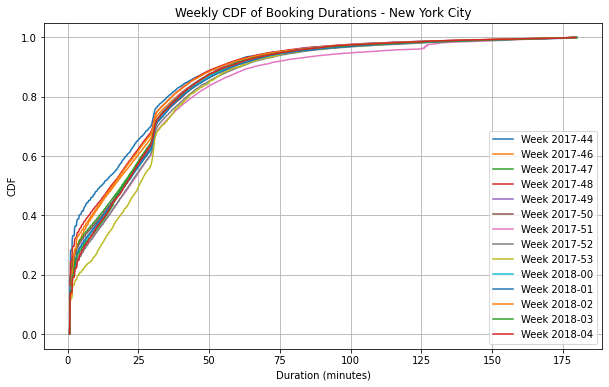

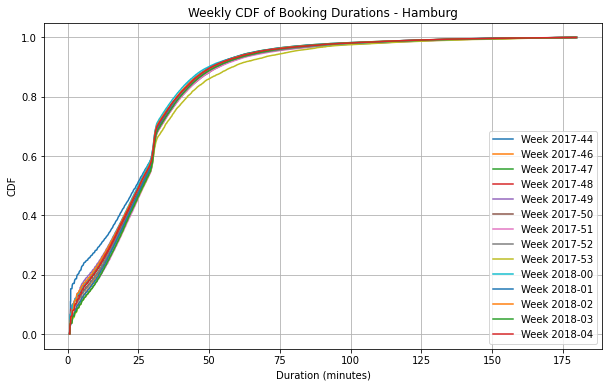

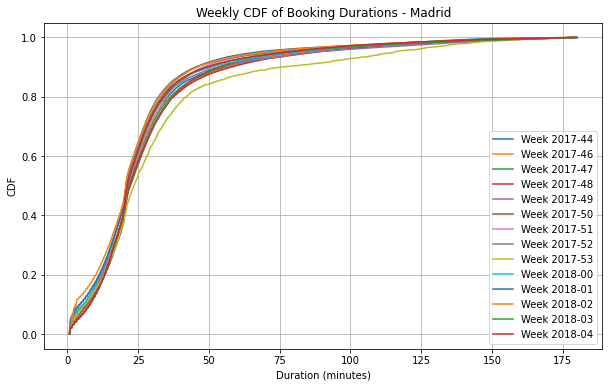

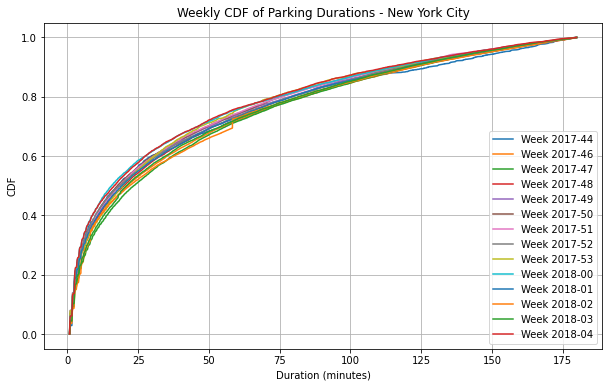

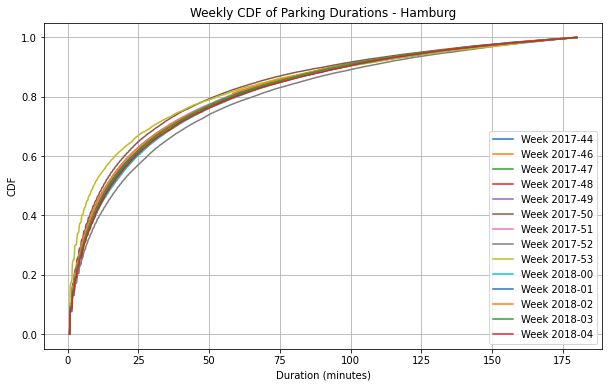

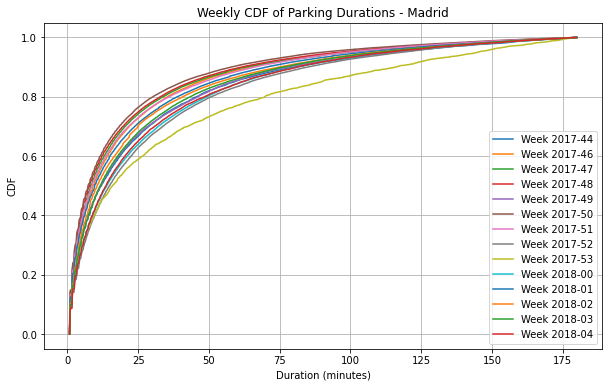

In [35]:
# Function to plot weekly CDFs
def plot_weekly_cdfs(weekly_data, title):
    for city, weeks in weekly_data.items():
        plt.figure(figsize=(10, 6))
        for week, durations in sorted(weeks.items()):
            if durations:  # Only plot if there is data
                durations_sorted = np.sort([d for d in durations if d<180])
                cdf = np.arange(len(durations_sorted)) / float(len(durations_sorted))
                plt.plot(durations_sorted, cdf, label=f"Week {week}")
        
        plt.title(f"{title} - {city}")
        plt.xlabel("Duration (minutes)")
        plt.ylabel("CDF")
        plt.legend()
        plt.grid()
        plt.show()

# Plot weekly CDFs for booking and parking durations
plot_weekly_cdfs(weekly_booking_durations, "Weekly CDF of Booking Durations")
plot_weekly_cdfs(weekly_parking_durations, "Weekly CDF of Parking Durations")

We see that generally the shape of the curve of the CDF for each city reamins the same regardless of the week choose to plot this data for. This can be considered as a characteristic.
Maybe people tend to have a certain preference or maybe the routes and the size of the city is playing a role here. There can be many different reason present here that leads to a certain shape/characteristic of car sharing usage.

### 2.2 Consider the system utilization over time: aggregate rentals per hour of the day, and then plot the number of booked/parked cars (or percentage of booked/parked cars) per hour versus time of day. Do you notice any outliers? Can you explain them?

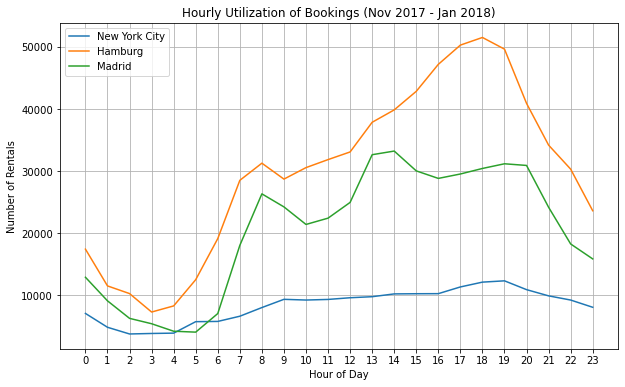

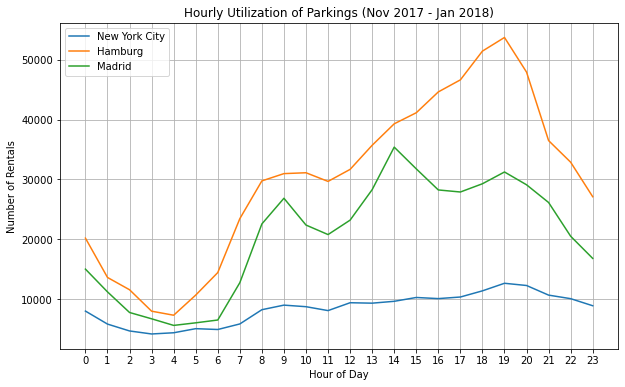

In [36]:
# Define cities and time period
cities = ["New York City", "Hamburg", "Madrid"]
start_date = datetime.datetime(2017, 11, 1)
end_date = datetime.datetime(2018, 1, 31)

# Function to retrieve hourly rentals (bookings or parkings)
def get_hourly_rentals(collection, cities, start_date, end_date):
    hourly_counts = {city: [0] * 24 for city in cities}  # Initialize count array for each hour

    for city in cities:
        cursor = collection.find({
            "city": city,
            "init_date": {"$gte": start_date, "$lt": end_date}
        }, {"init_date": 1})
        
        for doc in cursor:
            hour = doc["init_date"].hour  # Extract the hour of the day
            hourly_counts[city][hour] += 1  # Increment the count for this hour
    
    return hourly_counts

# Retrieve hourly counts for bookings and parkings
hourly_booking_counts = get_hourly_rentals(bookings, cities, start_date, end_date)
hourly_parking_counts = get_hourly_rentals(parkings, cities, start_date, end_date)

# Function to plot hourly utilization
def plot_hourly_utilization(hourly_data, title):
    plt.figure(figsize=(10, 6))
    hours = list(range(24))  # 24 hours in a day
    
    for city, counts in hourly_data.items():
        plt.plot(hours, counts, label=city)
    
    plt.title(title)
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Rentals")
    plt.xticks(hours)
    plt.legend()
    plt.grid()
    plt.show()

# Plot hourly utilization for bookings and parkings
plot_hourly_utilization(hourly_booking_counts, "Hourly Utilization of Bookings (Nov 2017 - Jan 2018)")
plot_hourly_utilization(hourly_parking_counts, "Hourly Utilization of Parkings (Nov 2017 - Jan 2018)")

We can see different peaks through out the day for each city. In the morning, midday and the afternoon there are peaks which indicate people are generally more using the car sharing to get to their job or return back home.
Again each city has a distinct characteristic in this sense. While Hamburg city using car sharing the most at night more than other hours, a city like New York City keep the rate of usage consistent through out the day and we don't see very sharp peaks in the usage.

### 2.3 Derive a criterion to filter possible outliers (e.g., booking periods that are too short/too long), to obtain rentals from bookings, filtering system issues or problems with the data collection.

We have already filtered the "too long" rentals. Now we can apply the filter also for the "too short" trips. The criterion we use for the filter is a simple comparison with a fixed threshold of a time that seems reasonble. For "too long" trips we already considered 2-3 hours and now we can consider less than a minute trips as "too short"

### 2.4 System Utilization of filtered data through time for cities

In [37]:
cities = ["New York City", "Hamburg", "Madrid"]
start_date = datetime.datetime(2017, 11, 1)
end_date = datetime.datetime(2018, 1, 31)

# Function to retrieve hourly rentals with duration filtering
def get_hourly_rentals_filtered(collection, cities, start_date, end_date, min_duration=2, max_duration=120):
    hourly_counts = {city: [0] * 24 for city in cities}  # Initialize count array for each hour

    for city in cities:
        cursor = collection.find({
            "city": city,
            "init_date": {"$gte": start_date, "$lt": end_date},
            "final_date": {"$exists": True}  # Ensure final_date exists to calculate duration
        }, {"init_date": 1, "final_date": 1})
        
        for doc in cursor:
            duration = (doc["final_date"] - doc["init_date"]).total_seconds() / 60  # Duration in minutes
            if min_duration <= duration <= max_duration:  # Apply duration filter
                hour = doc["init_date"].hour  # Extract the hour of the day
                hourly_counts[city][hour] += 1  # Increment the count for this hour
    
    return hourly_counts

# Retrieve hourly counts for bookings and parkings with duration filtering
hourly_booking_counts_filtered = get_hourly_rentals_filtered(bookings, cities, start_date, end_date)
hourly_parking_counts_filtered = get_hourly_rentals_filtered(parkings, cities, start_date, end_date)

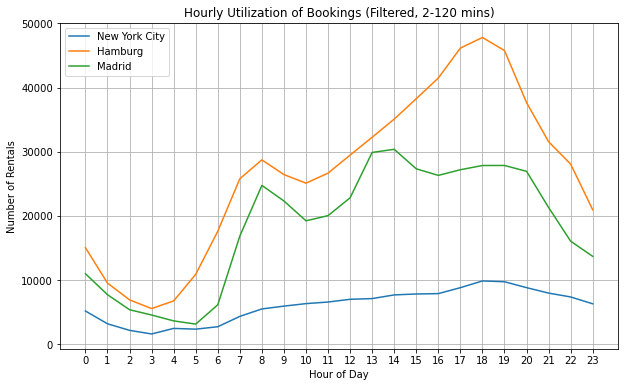

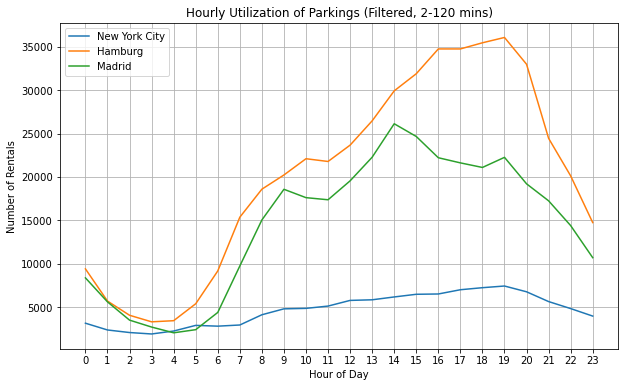

In [38]:
# Function to plot hourly utilization
def plot_hourly_utilization(hourly_data, title):
    plt.figure(figsize=(10, 6))
    hours = list(range(24))  # 24 hours in a day
    
    for city, counts in hourly_data.items():
        plt.plot(hours, counts, label=city)
    
    plt.title(title)
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Rentals")
    plt.xticks(hours)
    plt.legend()
    plt.grid()
    plt.show()

# Plot hourly utilization for bookings and parkings after filtering
plot_hourly_utilization(hourly_booking_counts_filtered, "Hourly Utilization of Bookings (Filtered, 2-120 mins)")
plot_hourly_utilization(hourly_parking_counts_filtered, "Hourly Utilization of Parkings (Filtered, 2-120 mins)")

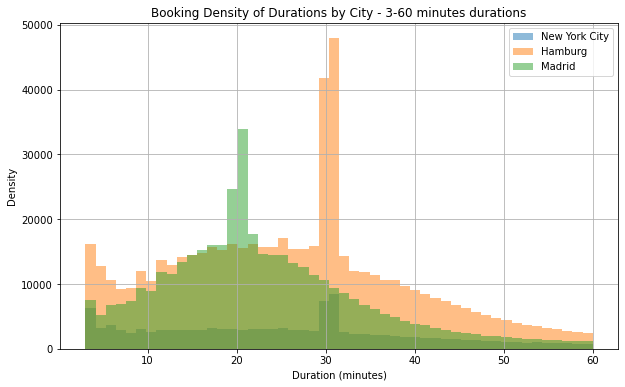

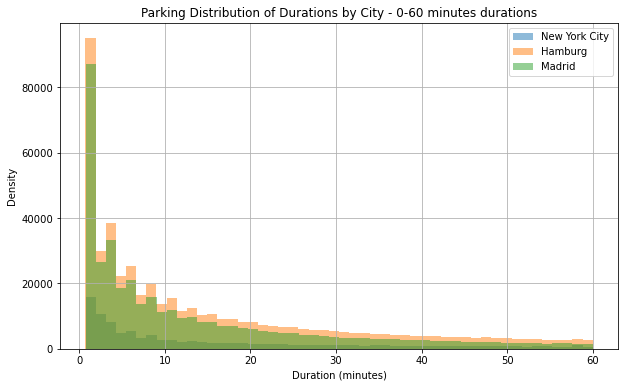

In [39]:
plt.figure(figsize=(10, 6))

for city, durations in booking_durations.items():
    plt.hist(
        [d for d in durations if d < 60 and d > 3], 
        bins=50, 
        alpha=0.5,  # Adjust alpha for transparency
        label=city
    )

plt.title("Booking Density of Durations by City - 3-60 minutes durations")
plt.xlabel("Duration (minutes)")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()



plt.figure(figsize=(10, 6))

for city, durations in parking_durations.items():
    plt.hist(
        [d for d in durations if d < 60], 
        bins=50, 
        alpha=0.5,  # Adjust alpha for transparency
        label=city
    )

plt.title("Parking Distribution of Durations by City - 0-60 minutes durations")
plt.xlabel("Duration (minutes)")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

With applying the filter on the Bookins, we obtain a simliar utilization curve for cities while the total number of rentals reduced. We still see three peaks for Hamburg, and Madrid cities and for the New York City, the curve is even smoother. The Density of the bookings duration is showing a more normal behaviour if we filter the "too short" and "too long" rentals.
Also there is a peak in 30 minutes for New York City and Hamburg and this peak is present in the Madrid for 20 minutes trips. This can be subjected to more exploration since the sharpness of this peak does not seem to be normal.
Since the distribution for bookings and parkings are very different, we might need to consider different lower bound for the filtering. While it is unlikely for a trip to last less than 1-2 minutes, it can be differnet for the parkings. A car can go through another rental upon as soon as it went to parking. The distribution of the duration for parkings and bookings show this.

### 2.5 compute the average, median, standard deviation, and percentiles of the booking/parking duration over time (e.g., per each day of the collection)

In [40]:
def get_daily_statistics(collection, cities, start_date, end_date, min_duration=2, max_duration=120):
    daily_stats = {city: [] for city in cities}  # Dictionary to store results for each city
    
    for city in cities:
        cursor = collection.find({
            "city": city,
            "init_date": {"$gte": start_date, "$lt": end_date},
            "final_date": {"$exists": True}  # Ensure final_date exists to calculate duration
        }, {"init_date": 1, "final_date": 1})
        
        # Group durations by day
        durations_by_day = {}
        for doc in cursor:
            duration = (doc["final_date"] - doc["init_date"]).total_seconds() / 60  # Duration in minutes
            if min_duration <= duration <= max_duration:  # Apply duration filter
                date_key = doc["init_date"].date()  # Get date part only
                if date_key not in durations_by_day:
                    durations_by_day[date_key] = []
                durations_by_day[date_key].append(duration)
        
        # Calculate statistics for each day
        for day, durations in durations_by_day.items():
            if durations:  # Ensure there are durations to calculate statistics
                day_stats = {
                    "date": day,
                    "mean": pd.Series(durations).mean(),
                    "median": pd.Series(durations).median(),
                    "std_dev": pd.Series(durations).std(),
                    "percentiles": {
                        "25th": pd.Series(durations).quantile(0.25),
                        "50th": pd.Series(durations).quantile(0.5),
                        "75th": pd.Series(durations).quantile(0.75),
                        "90th": pd.Series(durations).quantile(0.90)
                    }
                }
                daily_stats[city].append(day_stats)
    
    return daily_stats

# Retrieve daily statistics for bookings
daily_booking_stats = get_daily_statistics(bookings, cities, start_date, end_date)

# Display sample results
for city, stats in daily_booking_stats.items():
    print(f"\nDaily statistics for {city}:")
    for stat in stats[:5]:  # Display the first 5 days for brevity
        print(stat)


Daily statistics for New York City:
{'date': datetime.date(2017, 11, 1), 'mean': 29.19300985313255, 'median': 25.383333333333333, 'std_dev': 22.84719266438041, 'percentiles': {'25th': 11.283333333333333, '50th': 25.383333333333333, '75th': 38.53333333333333, '90th': 60.61333333333333}}
{'date': datetime.date(2017, 11, 2), 'mean': 26.597635135135135, 'median': 24.708333333333336, 'std_dev': 19.746426267065633, 'percentiles': {'25th': 11.716666666666667, '50th': 24.708333333333336, '75th': 35.88333333333333, '90th': 50.291666666666664}}
{'date': datetime.date(2017, 11, 13), 'mean': 29.177522935779816, 'median': 25.866666666666667, 'std_dev': 22.506183607443177, 'percentiles': {'25th': 12.35, '50th': 25.866666666666667, '75th': 37.733333333333334, '90th': 59.9166666666667}}
{'date': datetime.date(2017, 11, 14), 'mean': 27.08931854516387, 'median': 24.525, 'std_dev': 21.369072999526114, 'percentiles': {'25th': 9.287500000000001, '50th': 24.525, '75th': 35.80416666666667, '90th': 56.154999

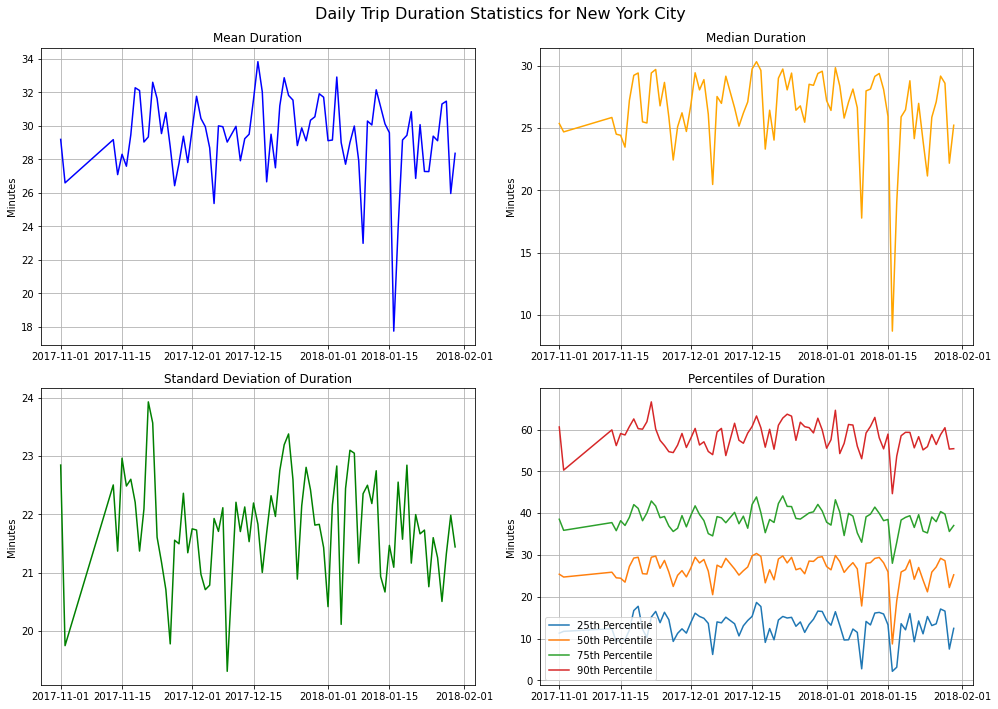

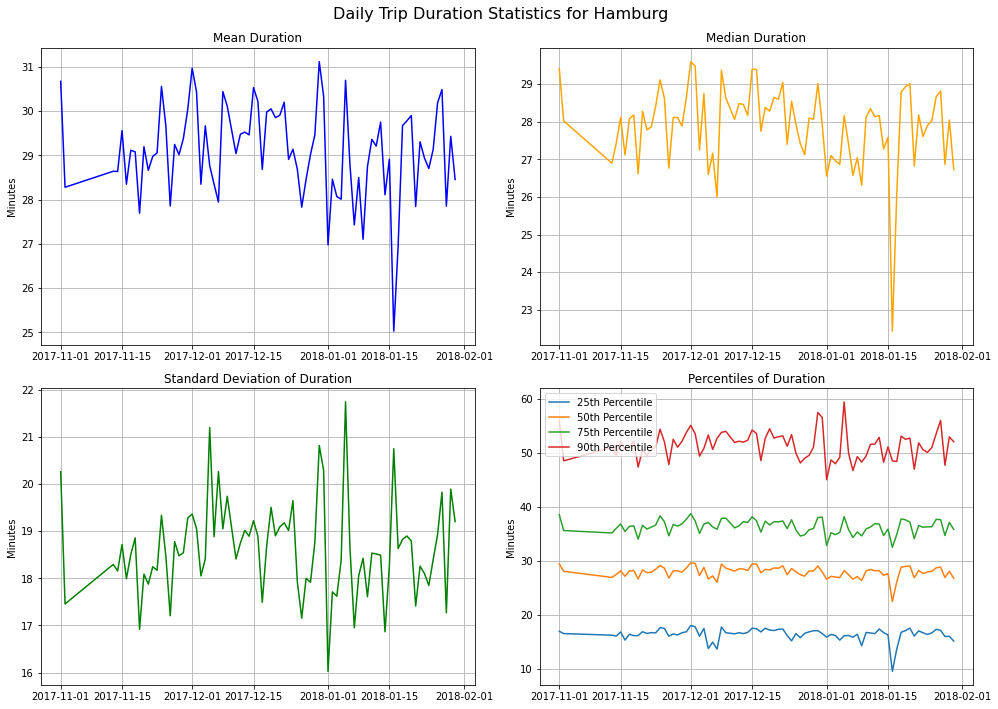

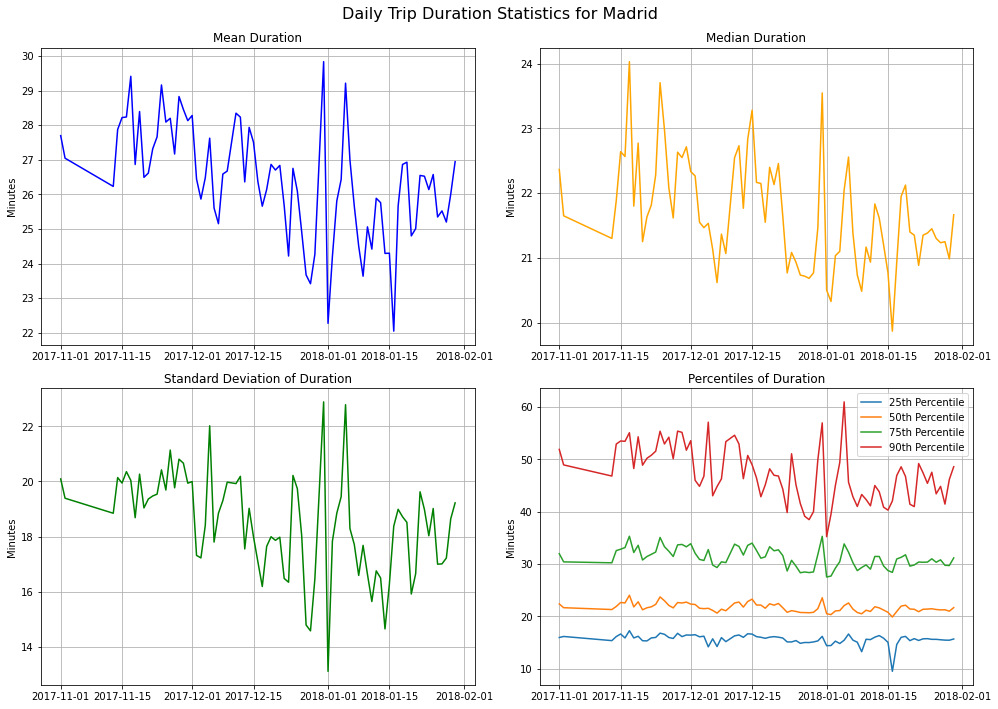

In [41]:
# Convert daily statistics to DataFrames for easier plotting
def create_df_from_stats(daily_stats):
    stats_df = {}
    for city, stats in daily_stats.items():
        # Create a DataFrame from the list of daily stats
        stats_df[city] = pd.DataFrame(stats).set_index("date")
    return stats_df

def plot_city_statistics(stats_df, city):
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Daily Trip Duration Statistics for {city}", fontsize=16)

    # Plot Mean
    axs[0, 0].plot(stats_df[city].index, stats_df[city]["mean"], color="blue", label="Mean")
    axs[0, 0].set_title("Mean Duration")
    axs[0, 0].set_ylabel("Minutes")
    axs[0, 0].grid(True)

    # Plot Median
    axs[0, 1].plot(stats_df[city].index, stats_df[city]["median"], color="orange", label="Median")
    axs[0, 1].set_title("Median Duration")
    axs[0, 1].set_ylabel("Minutes")
    axs[0, 1].grid(True)

    # Plot Standard Deviation
    axs[1, 0].plot(stats_df[city].index, stats_df[city]["std_dev"], color="green", label="Std. Dev")
    axs[1, 0].set_title("Standard Deviation of Duration")
    axs[1, 0].set_ylabel("Minutes")
    axs[1, 0].grid(True)

    # Plot Percentiles
    for percentile in ["25th", "50th", "75th", "90th"]:
        axs[1, 1].plot(stats_df[city].index, stats_df[city]["percentiles"].apply(lambda x: x[percentile]), label=f"{percentile} Percentile")
    axs[1, 1].set_title("Percentiles of Duration")
    axs[1, 1].set_ylabel("Minutes")
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # Display plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Convert stats to DataFrame
stats_df = create_df_from_stats(daily_booking_stats)

# Plot for each city
for city in cities:
    plot_city_statistics(stats_df, city)

#### 2.5.a  Do these figures change over time?

The mean of durations change of time and it shows for some dates there are peaks and for some dates there are dips. Genrally for the weekneds we have some peaks and for the holidays we have some dips.

#### 2.5.b  Is it possible to spot any periodicity (e.g., weekends vs weekdays, holidays versus working periods)?

The values shows periodicity over time and moslty they are week dependent. Every 7 days we can detect the pattern is kind of repeating itself and it is due to some fixed dates such as weekends and the start of the weekdays.

#### 2.5.c Is it possible to spot any trend (e.g., increasing, decreasing, holiday periods)?

The periodic trend is always there. Also for a date such as the new year's eve, we see there is a large peak while the next mornig we see a large dip in a city like New York City which is very famous for its new year's celebrations. While there are other dates in european countries which shows this peak-dip behaviour.

### 2.6 For the city of Milano, correlate the probability of a rental with the availability of other transport means.

In [42]:
for booking in bookings.find({"city": "Milano", "walking.duration": {"$gt": -1}}):
    print(booking)
    break

{'_id': ObjectId('5900e8ca2ad8531539ed6642'), 'init_fuel': 87, 'city': 'Milano', 'walking': {'duration': 1339, 'distance': 1800}, 'vendor': 'car2go', 'driving': {'duration': 316, 'distance': 1852}, 'final_time': 1481670054, 'plate': '574/FF106NT', 'engineType': 'CE', 'init_time': 1481668745, 'vin': 'WME4533421K150958', 'smartPhoneRequired': True, 'interior': 'GOOD', 'final_fuel': 87, 'exterior': 'GOOD', 'init_date': datetime.datetime(2016, 12, 13, 23, 39, 5), 'final_date': datetime.datetime(2016, 12, 14, 0, 0, 54), 'init_address': 'Via Gaspare Aselli, 25, 20133 Milano', 'final_address': 'Viale Lombardia, 27, 20131 Milano', 'origin_destination': {'type': 'LineString', 'coordinates': [[9.23008, 45.47082], [9.22361, 45.48337]]}, 'public_transport': {'duration': 1006, 'distance': 2090, 'arrival_date': datetime.datetime(2016, 12, 14, 0, 23, 28), 'arrival_time': 1481671408}}


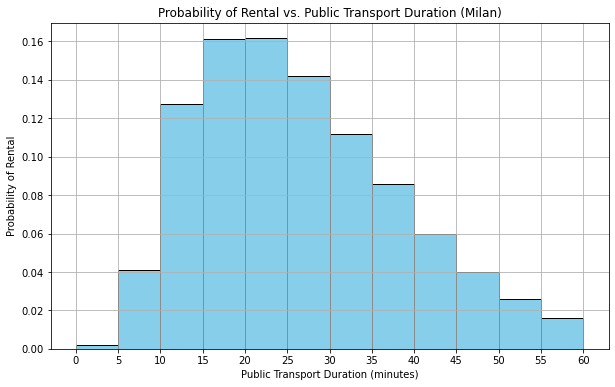

In [43]:
milan_rentals = bookings.find({
    "city": "Milano",
    "public_transport.duration": {"$gt": -1},
    "public_transport.distance": {"$gt": -1},
    "init_date": {"$gte": start_date, "$lt": end_date}
})

# Extract public transport durations in minutes
public_transport_durations = []
for rental in milan_rentals:
    public_transport_duration_minutes = rental["public_transport"]["duration"] / 60  # Convert seconds to minutes
    public_transport_durations.append(public_transport_duration_minutes)

# Define duration bins in minutes (e.g., 0-5, 5-10, 10-15, ...)
bin_edges = np.arange(0, 65, 5)  # e.g., up to 60 minutes, in 5-minute intervals
bins = np.digitize(public_transport_durations, bin_edges) - 1  # bin indices

# Count rentals per bin
bin_counts = Counter(bins)

# Compute total number of rentals
total_rentals = len(public_transport_durations)

# Probability of a rental in each bin
probabilities = {bin_edges[i]: bin_counts[i] / total_rentals for i in range(len(bin_edges)-1)}

# Plot the histogram of rental probabilities by public transport duration bin
plt.figure(figsize=(10, 6))
plt.bar(probabilities.keys(), probabilities.values(), width=5, align="edge", color="skyblue", edgecolor="black")
plt.xlabel("Public Transport Duration (minutes)")
plt.ylabel("Probability of Rental")
plt.title("Probability of Rental vs. Public Transport Duration (Milan)")
plt.xticks(bin_edges)
plt.grid()
plt.show()

The probability of renting a car over taking the public transport distribution shows that when the trip time is around 15 to 30 minutes, people tend to take the cars rather than using the public transport while when the duration of the public transportation trip is lower or higher the rate of using car sharing decrease.

### 2.7 check the position of the cars when booked and returned...

In [29]:
bookings = db["enjoy_PermanentBookings"]
# bookings = db["ActiveBookings"]

In [90]:
# hamburg_bookings = bookings.find({
#     "city": "Torino",
#     # "origin_destination": {"$exists": True},
#     # "origin_destination.coordinates": {"$size": 2},
# })

# # Convert cursor to list and check if it's empty
# hamburg_bookings_list = list(hamburg_bookings)
# if not hamburg_bookings_list:
#     raise ValueError("No bookings found. Please verify the query.")

# # Extract data and compute duration
# data = []
# for booking in hamburg_bookings_list:
#     try:
#         init_coords = booking["origin_destination"]["coordinates"][0]
#         final_coords = booking["origin_destination"]["coordinates"][1]
        
#         # Calculate duration in seconds
#         init_time = booking["init_time"]
#         final_time = booking["final_time"]
#         duration = final_time - init_time  # duration in seconds
        
#         # Filter by duration (2 to 60 minutes)
#         if not (120 <= duration <= 3600):
#             continue
        
#         start_hour = booking["init_date"].hour
#         end_hour = booking["final_date"].hour
#         day_of_week = booking["init_date"].weekday()
        
#         # Append the booking data to the list
#         data.append({
#             "init_geom": Point(init_coords),
#             "final_geom": Point(final_coords),
#             "start_hour": start_hour,
#             "end_hour": end_hour,
#             "day_of_week": day_of_week,
#             "duration": duration
#         })
#     except KeyError as e:
#         print(f"Skipping record due to missing data: {e}")

# # Verify that data has been added to the list
# if not data:
#     raise ValueError("No valid data extracted. Check MongoDB fields and structure.")

# # Convert to DataFrame and then to GeoDataFrame
# df = pd.DataFrame(data)
# gdf = gpd.GeoDataFrame(df, geometry="init_geom", crs="EPSG:4326")

In [64]:
# db["enjoy_PermanentBookings"].find_one({"city": "New York City"})["origin_destination"]["coordinates"][0][0]

In [79]:
# bookings = [db["PermanentBookings"].find_one({"city": "New York City"})]

In [80]:
data = list()
for booking in db["PermanentBookings"].find({"city": "New York City"}):
    init_date = booking["init_date"]
    final_date = booking["final_date"]
    orig_coords = booking["origin_destination"]["coordinates"][0]
    dest_coords = booking["origin_destination"]["coordinates"][1]
    data.append({
        "init_date": init_date,
        "final_date": final_date,
        "orig_longitude": orig_coords[0],
        "orig_latitude": orig_coords[1],
        "dest_longitude": dest_coords[0],
        "dest_latitude": dest_coords[1]
    })

# print(data)
df = pd.DataFrame(data, columns=['init_date', 'final_date', 'orig_longitude', 'orig_latitude', 'dest_longitude', 'dest_latitude'])

In [81]:
df

init_date          final_date  orig_longitude  orig_latitude  \
0      2016-12-13 12:39:08 2016-12-13 12:40:42       -73.95703       40.73284   
1      2016-12-13 12:39:53 2016-12-13 12:40:42       -73.93031       40.70373   
2      2016-12-13 12:41:31 2016-12-13 12:43:46       -73.95703       40.73284   
3      2016-12-13 12:38:23 2016-12-13 12:50:09       -73.91966       40.76482   
4      2016-12-13 12:47:46 2016-12-13 12:56:27       -74.00047       40.62907   
...                    ...                 ...             ...            ...   
747907 2018-01-31 08:02:59 2018-01-31 08:03:48       -73.96496       40.63871   
747908 2018-01-31 08:04:44 2018-01-31 08:06:31       -73.96577       40.63835   
747909 2018-01-31 08:04:44 2018-01-31 08:07:20       -73.95255       40.68454   
747910 2018-01-31 08:07:20 2018-01-31 08:09:08       -73.96496       40.63871   
747911 2018-01-31 08:09:08 2018-01-31 08:09:55       -73.98182       40.67953   

        dest_longitude  dest_latitude  
0            -73.95703       40.73284  
1            -73.93031       40.70373  
2            -73.95706       40.73278  
3            -73.90886       40.75435  
4            -73.99990       40.63443  
...                ...            ...  
747907       -73.96496       40.63871  
747908       -73.96577       40.63835  
747909       -73.95255       40.68454  
747910       -73.96496       40.63871  
747911       -73.98182       40.67953  

[747912 rows x 6 columns]

In [104]:
# Convert init_date and final_date to datetime
df['init_date'] = pd.to_datetime(df['init_date'])
df['final_date'] = pd.to_datetime(df['final_date'])

# Calculate trip duration in minutes
df['trip_duration'] = (df['final_date'] - df['init_date']).dt.total_seconds() / 60

# Filter rows where trip duration is between 2 and 60 minutes
filtered_df = df[(df['trip_duration'] >= 2) & (df['trip_duration'] <= 60)]

In [114]:
filtered_df

init_date          final_date  orig_longitude  orig_latitude  \
2      2016-12-13 12:41:31 2016-12-13 12:43:46       -73.95703       40.73284   
3      2016-12-13 12:38:23 2016-12-13 12:50:09       -73.91966       40.76482   
4      2016-12-13 12:47:46 2016-12-13 12:56:27       -74.00047       40.62907   
5      2016-12-13 12:43:00 2016-12-13 13:00:17       -73.98540       40.63011   
6      2016-12-13 12:44:32 2016-12-13 13:01:49       -73.97417       40.65545   
...                    ...                 ...             ...            ...   
747895 2018-01-31 07:47:53 2018-01-31 07:51:06       -73.95729       40.63110   
747901 2018-01-31 07:53:30 2018-01-31 08:10:45       -73.99282       40.65861   
747904 2018-01-31 07:55:12 2018-01-31 08:06:31       -73.95417       40.68888   
747906 2018-01-31 08:02:04 2018-01-31 08:10:45       -73.99701       40.63385   
747909 2018-01-31 08:04:44 2018-01-31 08:07:20       -73.95255       40.68454   

        dest_longitude  dest_latitude  trip_duration  
2            -73.95706       40.73278       2.250000  
3            -73.90886       40.75435      11.766667  
4            -73.99990       40.63443       8.683333  
5            -73.99395       40.63523      17.283333  
6            -73.97418       40.65544      17.283333  
...                ...            ...            ...  
747895       -73.95729       40.63110       3.216667  
747901       -74.01703       40.67730      17.250000  
747904       -73.93697       40.69161      11.316667  
747906       -73.99701       40.63385       8.683333  
747909       -73.95255       40.68454       2.600000  

[501712 rows x 7 columns]

In [177]:
df_sample = filtered_df.sample(50000)

In [178]:
df_sample['init_date'] = df_sample['init_date'].astype(str)
df_sample['final_date'] = df_sample['final_date'].astype(str)

In [179]:
df_sample.rename(columns={
    "orig_longitude": "start_longitude",
    "orig_latitude": "start_latitude",
    "dest_longitude": "end_longitude",
    "dest_latitude": "end_latitude",
}, inplace=True)

In [ ]:
# starting points --> origins 
geometry = gpd.points_from_xy(df_sample["start_longitude"], df_sample["start_latitude"], crs="EPSG:4326")
gdf = GeoDataFrame(df_sample, geometry=geometry)
gdf.explore()

In [ ]:
# starting points --> origins 
geometry = gpd.points_from_xy(df_sample["end_longitude"], df_sample["end_latitude"], crs="EPSG:4326")
gdf = GeoDataFrame(df_sample, geometry=geometry)
gdf.explore()

In [ ]:
df_sample['init_date'] = pd.to_datetime(df_sample['init_date'])
df_sample['final_date'] = pd.to_datetime(df_sample['final_date'])




# Filter 1: Trips on Mondays between 8:00-10:00
df_monday_8_10 = df_sample[
    (df_sample['init_date'].dt.weekday == 0) &  # Monday is weekday 0
    (df_sample['init_date'].dt.hour >= 8) &
    (df_sample['init_date'].dt.hour < 10)
]

# Filter 2: Trips on Mondays between 18:00-20:00
df_monday_18_20 = df_sample[
    (df_sample['init_date'].dt.weekday == 0) &
    (df_sample['init_date'].dt.hour >= 18) &
    (df_sample['init_date'].dt.hour < 20)
]

# Filter 3: Trips on the same time (e.g., 8:00-10:00) but on Wednesdays
df_wednesday_8_10 = df_sample[
    (df_sample['init_date'].dt.weekday == 2) &  # Wednesday is weekday 2
    (df_sample['init_date'].dt.hour >= 8) &
    (df_sample['init_date'].dt.hour < 10)
]

# Filter 4: Trips on weekends (Saturday and Sunday)
df_weekend = df_sample[
    (df_sample['init_date'].dt.weekday >= 5)  # Saturday is 5, Sunday is 6
]

# Filter 5: Trips on weekdays (Monday to Friday)
df_weekday = df_sample[
    (df_sample['init_date'].dt.weekday < 5)
]


df_monday_8_10['init_date'] = df_monday_8_10['init_date'].astype(str)
df_monday_8_10['final_date'] = df_monday_8_10['final_date'].astype(str)

df_monday_18_20['init_date'] = df_monday_18_20['init_date'].astype(str)
df_monday_18_20['final_date'] = df_monday_18_20['final_date'].astype(str)

df_wednesday_8_10['init_date'] = df_wednesday_8_10['init_date'].astype(str)
df_wednesday_8_10['final_date'] = df_wednesday_8_10['final_date'].astype(str)

df_weekend['init_date'] = df_weekend['init_date'].astype(str)
df_weekend['final_date'] = df_weekend['final_date'].astype(str)

df_weekday['init_date'] = df_weekday['init_date'].astype(str)
df_weekday['final_date'] = df_weekday['final_date'].astype(str)


#### In two different time on one day

In [186]:
# starting points --> origins 
geometry = gpd.points_from_xy(df_monday_8_10["start_longitude"], df_monday_8_10["start_latitude"], crs="EPSG:4326")
gdf = GeoDataFrame(df_monday_8_10, geometry=geometry)
gdf.explore()

In [187]:
# starting points --> origins 
geometry = gpd.points_from_xy(df_monday_18_20["start_longitude"], df_monday_18_20["start_latitude"], crs="EPSG:4326")
gdf = GeoDataFrame(df_monday_18_20, geometry=geometry)
gdf.explore()

In [191]:
# ending points --> destinations 
geometry = gpd.points_from_xy(df_monday_8_10["end_longitude"], df_monday_8_10["end_latitude"], crs="EPSG:4326")
gdf = GeoDataFrame(df_monday_8_10, geometry=geometry)
gdf.explore()

In [190]:
# ending points --> destinations 
geometry = gpd.points_from_xy(df_monday_18_20["end_longitude"], df_monday_18_20["end_latitude"], crs="EPSG:4326")
gdf = GeoDataFrame(df_monday_18_20, geometry=geometry)
gdf.explore()

#### in two differnent days, one fixed time

In [192]:
# starting points --> origins 
geometry = gpd.points_from_xy(df_monday_8_10["start_longitude"], df_monday_8_10["start_latitude"], crs="EPSG:4326")
gdf = GeoDataFrame(df_monday_8_10, geometry=geometry)
gdf.explore()

In [193]:
# starting points --> origins 
geometry = gpd.points_from_xy(df_wednesday_8_10["start_longitude"], df_wednesday_8_10["start_latitude"], crs="EPSG:4326")
gdf = GeoDataFrame(df_wednesday_8_10, geometry=geometry)
gdf.explore()

In [194]:
# ending points --> destinations 
geometry = gpd.points_from_xy(df_monday_8_10["end_longitude"], df_monday_8_10["end_latitude"], crs="EPSG:4326")
gdf = GeoDataFrame(df_monday_8_10, geometry=geometry)
gdf.explore()

In [195]:
# ending points --> destinations 
geometry = gpd.points_from_xy(df_wednesday_8_10["end_longitude"], df_wednesday_8_10["end_latitude"], crs="EPSG:4326")
gdf = GeoDataFrame(df_wednesday_8_10, geometry=geometry)
gdf.explore()

#### weekday vs weekned

In [ ]:
# starting points --> origins 
geometry = gpd.points_from_xy(df_weekday["end_longitude"], df_weekday["end_latitude"], crs="EPSG:4326")
gdf = GeoDataFrame(df_weekday, geometry=geometry)
gdf.explore()

In [ ]:
# starting points --> origins 
geometry = gpd.points_from_xy(df_weekend["end_longitude"], df_weekend["end_latitude"], crs="EPSG:4326")
gdf = GeoDataFrame(df_weekend, geometry=geometry)
gdf.explore()

In [ ]:
# ending points --> destinations 
geometry = gpd.points_from_xy(df_weekday["end_longitude"], df_weekday["end_latitude"], crs="EPSG:4326")
gdf = GeoDataFrame(df_weekday, geometry=geometry)
gdf.explore()

In [ ]:
# ending points --> destinations 
geometry = gpd.points_from_xy(df_weekend["end_longitude"], df_weekend["end_latitude"], crs="EPSG:4326")
gdf = GeoDataFrame(df_weekend, geometry=geometry)
gdf.explore()

### Trip generation and heat map

In [154]:
# df_sample.rename(columns={
#     "orig_longitude": "start_longitude",
#     "orig_latitude": "start_latitude",
#     "dest_longitude": "end_longitude",
#     "dest_latitude": "end_latitude",
# }, inplace=True)

In [142]:
min_lon=min(df_sample["start_longitude"].min(),df_sample["end_longitude"].min())
max_lon=max(df_sample["start_longitude"].max(),df_sample["end_longitude"].max())
min_lat=min(df_sample["start_latitude"].min(),df_sample["end_latitude"].min())
max_lat=max(df_sample["start_latitude"].max(),df_sample["end_latitude"].max())

bottomLeft = (min_lat, min_lon)
bottomRight = (min_lat, max_lon)
topLeft = (max_lat, min_lon)
topRight = (max_lat, max_lon)

Number_zones_total=42

x=int(math.sqrt(Number_zones_total))+1  #these are the number of points dividing the range for coordinates (lat and long)
cols = np.linspace(bottomLeft[1]-0.00001, bottomRight[1]+0.00001, num=x) #these are the indexes for longitude 
rows = np.linspace(bottomLeft[0]-0.00001, topLeft[0]+0.00001, num=x) #these are the indexes for latitude 

In [143]:
df_sample['col_start'] = np.searchsorted(cols, df_sample["start_longitude"])
df_sample['row_start'] = np.searchsorted(rows, df_sample["start_latitude"])

df_sample['col_end'] = np.searchsorted(cols, df_sample["end_longitude"])
df_sample['row_end'] = np.searchsorted(rows, df_sample["end_latitude"])

df_sample["zone_id_start"] = df_sample["row_start"].astype(str) + df_sample["col_start"].astype(str)
df_sample["zone_id_end"] = df_sample["row_end"].astype(str) + df_sample["col_end"].astype(str)

In [144]:
# First, we count how many trips are starting from each zone
res_origin=df_sample.groupby(['row_start','col_start','zone_id_start'])['zone_id_start'].count().reset_index(name='count') 
#Then, we count the total number of trips
sum_origin=res_origin["count"].sum()
#The proabability is estimated as the fraction of trips
res_origin["prob_origin"]=res_origin["count"]/sum_origin
res_origin=res_origin.rename(columns={"count": "count_origin"})
res_origin

row_start  col_start zone_id_start  count_origin  prob_origin
0           1          1            11            97       0.0097
1           1          2            12           516       0.0516
2           2          1            21           539       0.0539
3           2          2            22           793       0.0793
4           2          3            23           180       0.0180
5           3          1            31           446       0.0446
6           3          2            32          1227       0.1227
7           3          3            33           586       0.0586
8           3          4            34            39       0.0039
9           4          1            41            86       0.0086
10          4          2            42          1278       0.1278
11          4          3            43          1650       0.1650
12          4          4            44           380       0.0380
13          4          5            45             1       0.0001
14          4          6            46             1       0.0001
15          5          2            52           145       0.0145
16          5          3            53          1337       0.1337
17          5          4            54            93       0.0093
18          6          3            63           289       0.0289
19          6          4            64           317       0.0317

In [145]:
#Now repeat everything for destinations
res_dest=df_sample.groupby(['row_end','col_end','zone_id_end'])['zone_id_end'].count().reset_index(name='count') 
sum_destination=res_dest["count"].sum()
res_dest["prob_destination"]=res_dest["count"]/sum_destination
res_dest=res_dest.rename(columns={"count": "count_destination"})
res_dest

row_end  col_end zone_id_end  count_destination  prob_destination
0         1        1          11                 89            0.0089
1         1        2          12                506            0.0506
2         2        1          21                562            0.0562
3         2        2          22                762            0.0762
4         2        3          23                203            0.0203
5         3        1          31                457            0.0457
6         3        2          32               1232            0.1232
7         3        3          33                539            0.0539
8         3        4          34                 45            0.0045
9         4        1          41                 91            0.0091
10        4        2          42               1264            0.1264
11        4        3          43               1705            0.1705
12        4        4          44                367            0.0367
13        4        6          46                  3            0.0003
14        5        2          52                147            0.0147
15        5        3          53               1332            0.1332
16        5        4          54                 93            0.0093
17        6        3          63                290            0.0290
18        6        4          64                313            0.0313

In [146]:
#merge the two previous dataframes
trip_generation=res_dest.merge(res_origin[["count_origin", "prob_origin","zone_id_start"]], left_on='zone_id_end', right_on='zone_id_start').reset_index()
trip_generation=trip_generation.rename(columns={"row_end": "row", "col_end": "col", "zone_id_end": "zone_id"})
trip_generation

index  row  col zone_id  count_destination  prob_destination  \
0       0    1    1      11                 89            0.0089   
1       1    1    2      12                506            0.0506   
2       2    2    1      21                562            0.0562   
3       3    2    2      22                762            0.0762   
4       4    2    3      23                203            0.0203   
5       5    3    1      31                457            0.0457   
6       6    3    2      32               1232            0.1232   
7       7    3    3      33                539            0.0539   
8       8    3    4      34                 45            0.0045   
9       9    4    1      41                 91            0.0091   
10     10    4    2      42               1264            0.1264   
11     11    4    3      43               1705            0.1705   
12     12    4    4      44                367            0.0367   
13     13    4    6      46                  3            0.0003   
14     14    5    2      52                147            0.0147   
15     15    5    3      53               1332            0.1332   
16     16    5    4      54                 93            0.0093   
17     17    6    3      63                290            0.0290   
18     18    6    4      64                313            0.0313   

    count_origin  prob_origin zone_id_start  
0             97       0.0097            11  
1            516       0.0516            12  
2            539       0.0539            21  
3            793       0.0793            22  
4            180       0.0180            23  
5            446       0.0446            31  
6           1227       0.1227            32  
7            586       0.0586            33  
8             39       0.0039            34  
9             86       0.0086            41  
10          1278       0.1278            42  
11          1650       0.1650            43  
12           380       0.0380            44  
13             1       0.0001            46  
14           145       0.0145            52  
15          1337       0.1337            53  
16            93       0.0093            54  
17           289       0.0289            63  
18           317       0.0317            64

In [147]:
# We need to associate to each trip in the dataset the probability of its zone
df_prob=df_sample.merge(trip_generation[["prob_destination","zone_id"]], left_on='zone_id_end', right_on='zone_id')\
              .merge(trip_generation[["prob_origin","zone_id"]], left_on='zone_id_start', right_on='zone_id')
df_prob

init_date           final_date  start_longitude  \
0     2017-08-06 06:39:16  2017-08-06 06:40:12        -73.96700   
1     2017-02-20 17:09:59  2017-02-20 17:24:56        -73.92271   
2     2017-11-16 23:52:33  2017-11-16 23:53:22        -73.98649   
3     2017-10-24 19:33:03  2017-10-24 20:02:45        -73.94253   
4     2017-09-21 17:01:22  2017-09-21 17:02:58        -73.95903   
...                   ...                  ...              ...   
9994  2017-11-24 09:06:51  2017-11-24 09:42:59        -73.96538   
9995  2017-07-22 11:44:47  2017-07-22 12:14:46        -73.94538   
9996  2017-08-28 18:53:40  2017-08-28 19:28:50        -73.94524   
9997  2017-10-27 23:20:57  2017-10-27 23:32:29        -73.91191   
9998  2017-08-27 19:30:13  2017-08-27 19:43:41        -73.97573   

      start_latitude  end_longitude  end_latitude  trip_duration  col_start  \
0           40.64032      -73.96700      40.64032       0.933333          2   
1           40.70870      -73.92271      40.70870      14.950000          3   
2           40.68521      -73.98649      40.68521       0.816667          2   
3           40.68715      -73.94253      40.68715      29.700000          3   
4           40.63351      -73.95903      40.63351       1.600000          3   
...              ...            ...           ...            ...        ...   
9994        40.71712      -73.92415      40.68254      36.133333          2   
9995        40.66567      -73.94538      40.66567      29.983333          3   
9996        40.72399      -73.94862      40.72680      35.166667          3   
9997        40.69504      -73.91191      40.69504      11.533333          4   
9998        40.69753      -73.95337      40.71300      13.466667          2   

      row_start  col_end  row_end zone_id_start zone_id_end  prob_destination  \
0             2        2        2            22          22            0.0762   
1             4        3        4            43          43            0.1705   
2             4        2        4            42          42            0.1264   
3             4        3        4            43          43            0.1705   
4             2        3        2            23          23            0.0203   
...         ...      ...      ...           ...         ...               ...   
9994          5        3        4            52          43            0.1705   
9995          3        3        3            33          33            0.0539   
9996          5        3        5            53          53            0.1332   
9997          4        4        4            44          44            0.0367   
9998          4        3        4            42          43            0.1705   

     zone_id_x  prob_origin zone_id_y  
0           22       0.0793        22  
1           43       0.1650        43  
2           42       0.1278        42  
3           43       0.1650        43  
4           23       0.0180        23  
...        ...          ...       ...  
9994        43       0.0145        52  
9995        33       0.0586        33  
9996        53       0.1337        53  
9997        44       0.0380        44  
9998        43       0.1278        42  

[9999 rows x 17 columns]

In [148]:
#Now we can compute the loglikelihood of the samples
#origin
logLikelihoodOrigin=1/len(df_prob)*sum(np.log(df_prob["prob_origin"]))
logLikelihoodOrigin

-2.5249638086884305

In [149]:
#Now we can compute the loglikelihood of the samples
#destinatin
logLikelihoodDestination=1/len(df_prob)*sum(np.log(df_prob["prob_destination"]))
logLikelihoodDestination

-2.524941057224719

In [150]:
trip_generation["lon_min"]=cols[trip_generation["col"]-1]
trip_generation["lon_max"]=cols[trip_generation["col"]]
trip_generation["lat_min"]=rows[trip_generation["row"]-1]
trip_generation["lat_max"]=rows[trip_generation["row"]]

In [151]:
# from shapely.geometry import Point, Polygon

#Now we create the four vertices for each zone
trip_generation['A'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_min), axis=1)
trip_generation['B'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_min), axis=1)
trip_generation['C'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_max), axis=1)
trip_generation['D'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_max), axis=1)

#finally, we create the polygon (rectangle) with its four vertices
trip_generation['geometry']=trip_generation.apply(lambda row: Polygon([row.A, row.B,row.C,row.D]), axis=1)

C:\Users\Saeed\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\Saeed\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\Saeed\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:130: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\Saeed\AppData\Local\Programs\Python\Python39\lib\site-packages\p

In [152]:
#We show the zones with their probability of origin
gdf_gen = GeoDataFrame(trip_generation["prob_origin"], geometry=trip_generation.geometry, crs="EPSG:4326")   
gdf_gen.explore(column='prob_origin',tooltip='prob_origin')

In [153]:
#We show the zones with their probability of destination
gdf_dest = GeoDataFrame(trip_generation["prob_destination"], geometry=trip_generation.geometry, crs="EPSG:4326")   
gdf_dest.explore(column='prob_destination',tooltip='prob_destination')

### Trip generation and Heatmap on different times and days compared

#### ONe day, two differnt times

In [201]:
min_lon=min(df_wednesday_8_10["start_longitude"].min(),df_wednesday_8_10["end_longitude"].min())
max_lon=max(df_wednesday_8_10["start_longitude"].max(),df_wednesday_8_10["end_longitude"].max())
min_lat=min(df_wednesday_8_10["start_latitude"].min(),df_wednesday_8_10["end_latitude"].min())
max_lat=max(df_wednesday_8_10["start_latitude"].max(),df_wednesday_8_10["end_latitude"].max())

bottomLeft = (min_lat, min_lon)
bottomRight = (min_lat, max_lon)
topLeft = (max_lat, min_lon)
topRight = (max_lat, max_lon)

Number_zones_total = 42

x=int(math.sqrt(Number_zones_total))+1  #these are the number of points dividing the range for coordinates (lat and long)
cols = np.linspace(bottomLeft[1]-0.00001, bottomRight[1]+0.00001, num=x) #these are the indexes for longitude 
rows = np.linspace(bottomLeft[0]-0.00001, topLeft[0]+0.00001, num=x) #these are the indexes for latitude 


df_wednesday_8_10['col_start'] = np.searchsorted(cols, df_wednesday_8_10["start_longitude"])
df_wednesday_8_10['row_start'] = np.searchsorted(rows, df_wednesday_8_10["start_latitude"])

df_wednesday_8_10['col_end'] = np.searchsorted(cols, df_wednesday_8_10["end_longitude"])
df_wednesday_8_10['row_end'] = np.searchsorted(rows, df_wednesday_8_10["end_latitude"])

df_wednesday_8_10["zone_id_start"] = df_wednesday_8_10["row_start"].astype(str) + df_wednesday_8_10["col_start"].astype(str)
df_wednesday_8_10["zone_id_end"] = df_wednesday_8_10["row_end"].astype(str) + df_wednesday_8_10["col_end"].astype(str)


# First, we count how many trips are starting from each zone
res_origin=df_wednesday_8_10.groupby(['row_start','col_start','zone_id_start'])['zone_id_start'].count().reset_index(name='count') 
#Then, we count the total number of trips
sum_origin=res_origin["count"].sum()
#The proabability is estimated as the fraction of trips
res_origin["prob_origin"]=res_origin["count"]/sum_origin
res_origin=res_origin.rename(columns={"count": "count_origin"})
# res_origin


#Now repeat everything for destinations
res_dest=df_wednesday_8_10.groupby(['row_end','col_end','zone_id_end'])['zone_id_end'].count().reset_index(name='count') 
sum_destination=res_dest["count"].sum()
res_dest["prob_destination"]=res_dest["count"]/sum_destination
res_dest=res_dest.rename(columns={"count": "count_destination"})
# res_dest


#merge the two previous dataframes
trip_generation=res_dest.merge(res_origin[["count_origin", "prob_origin","zone_id_start"]], left_on='zone_id_end', right_on='zone_id_start').reset_index()
trip_generation=trip_generation.rename(columns={"row_end": "row", "col_end": "col", "zone_id_end": "zone_id"})
trip_generation

# We need to associate to each trip in the dataset the probability of its zone
df_prob=df_wednesday_8_10.merge(trip_generation[["prob_destination","zone_id"]], left_on='zone_id_end', right_on='zone_id')\
              .merge(trip_generation[["prob_origin","zone_id"]], left_on='zone_id_start', right_on='zone_id')
# df_prob


trip_generation["lon_min"]=cols[trip_generation["col"]-1]
trip_generation["lon_max"]=cols[trip_generation["col"]]
trip_generation["lat_min"]=rows[trip_generation["row"]-1]
trip_generation["lat_max"]=rows[trip_generation["row"]]


# from shapely.geometry import Point, Polygon

#Now we create the four vertices for each zone
trip_generation['A'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_min), axis=1)
trip_generation['B'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_min), axis=1)
trip_generation['C'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_max), axis=1)
trip_generation['D'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_max), axis=1)

#finally, we create the polygon (rectangle) with its four vertices
trip_generation['geometry']=trip_generation.apply(lambda row: Polygon([row.A, row.B,row.C,row.D]), axis=1)


#We show the zones with their probability of origin
gdf_gen = GeoDataFrame(trip_generation["prob_origin"], geometry=trip_generation.geometry, crs="EPSG:4326")   
gdf_gen.explore(column='prob_origin',tooltip='prob_origin')

C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\3460073193.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monday_8_10['col_start'] = np.searchsorted(cols, df_monday_8_10["start_longitude"])
C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\3460073193.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monday_8_10['row_start'] = np.searchsorted(rows, df_monday_8_10["start_latitude"])
C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\3460073193.py:21: SettingWithCopyWarning: 
A value is trying 

In [202]:
min_lon=min(df_monday_18_20["start_longitude"].min(),df_monday_18_20["end_longitude"].min())
max_lon=max(df_monday_18_20["start_longitude"].max(),df_monday_18_20["end_longitude"].max())
min_lat=min(df_monday_18_20["start_latitude"].min(),df_monday_18_20["end_latitude"].min())
max_lat=max(df_monday_18_20["start_latitude"].max(),df_monday_18_20["end_latitude"].max())

bottomLeft = (min_lat, min_lon)
bottomRight = (min_lat, max_lon)
topLeft = (max_lat, min_lon)
topRight = (max_lat, max_lon)

Number_zones_total = 42

x=int(math.sqrt(Number_zones_total))+1  #these are the number of points dividing the range for coordinates (lat and long)
cols = np.linspace(bottomLeft[1]-0.00001, bottomRight[1]+0.00001, num=x) #these are the indexes for longitude 
rows = np.linspace(bottomLeft[0]-0.00001, topLeft[0]+0.00001, num=x) #these are the indexes for latitude 


df_monday_18_20['col_start'] = np.searchsorted(cols, df_monday_18_20["start_longitude"])
df_monday_18_20['row_start'] = np.searchsorted(rows, df_monday_18_20["start_latitude"])

df_monday_18_20['col_end'] = np.searchsorted(cols, df_monday_18_20["end_longitude"])
df_monday_18_20['row_end'] = np.searchsorted(rows, df_monday_18_20["end_latitude"])

df_monday_18_20["zone_id_start"] = df_monday_18_20["row_start"].astype(str) + df_monday_18_20["col_start"].astype(str)
df_monday_18_20["zone_id_end"] = df_monday_18_20["row_end"].astype(str) + df_monday_18_20["col_end"].astype(str)


# First, we count how many trips are starting from each zone
res_origin=df_monday_18_20.groupby(['row_start','col_start','zone_id_start'])['zone_id_start'].count().reset_index(name='count') 
#Then, we count the total number of trips
sum_origin=res_origin["count"].sum()
#The proabability is estimated as the fraction of trips
res_origin["prob_origin"]=res_origin["count"]/sum_origin
res_origin=res_origin.rename(columns={"count": "count_origin"})
# res_origin


#Now repeat everything for destinations
res_dest=df_monday_18_20.groupby(['row_end','col_end','zone_id_end'])['zone_id_end'].count().reset_index(name='count') 
sum_destination=res_dest["count"].sum()
res_dest["prob_destination"]=res_dest["count"]/sum_destination
res_dest=res_dest.rename(columns={"count": "count_destination"})
# res_dest


#merge the two previous dataframes
trip_generation=res_dest.merge(res_origin[["count_origin", "prob_origin","zone_id_start"]], left_on='zone_id_end', right_on='zone_id_start').reset_index()
trip_generation=trip_generation.rename(columns={"row_end": "row", "col_end": "col", "zone_id_end": "zone_id"})
trip_generation

# We need to associate to each trip in the dataset the probability of its zone
df_prob=df_monday_18_20.merge(trip_generation[["prob_destination","zone_id"]], left_on='zone_id_end', right_on='zone_id')\
              .merge(trip_generation[["prob_origin","zone_id"]], left_on='zone_id_start', right_on='zone_id')
# df_prob


trip_generation["lon_min"]=cols[trip_generation["col"]-1]
trip_generation["lon_max"]=cols[trip_generation["col"]]
trip_generation["lat_min"]=rows[trip_generation["row"]-1]
trip_generation["lat_max"]=rows[trip_generation["row"]]


# from shapely.geometry import Point, Polygon

#Now we create the four vertices for each zone
trip_generation['A'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_min), axis=1)
trip_generation['B'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_min), axis=1)
trip_generation['C'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_max), axis=1)
trip_generation['D'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_max), axis=1)

#finally, we create the polygon (rectangle) with its four vertices
trip_generation['geometry']=trip_generation.apply(lambda row: Polygon([row.A, row.B,row.C,row.D]), axis=1)


#We show the zones with their probability of origin
gdf_gen = GeoDataFrame(trip_generation["prob_origin"], geometry=trip_generation.geometry, crs="EPSG:4326")   
gdf_gen.explore(column='prob_origin',tooltip='prob_origin')

C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\1174887435.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monday_18_20['col_start'] = np.searchsorted(cols, df_monday_18_20["start_longitude"])
C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\1174887435.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monday_18_20['row_start'] = np.searchsorted(rows, df_monday_18_20["start_latitude"])
C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\1174887435.py:21: SettingWithCopyWarning: 
A value is try

#### Two days, one fixed time

In [203]:
min_lon=min(df_wednesday_8_10["start_longitude"].min(),df_wednesday_8_10["end_longitude"].min())
max_lon=max(df_wednesday_8_10["start_longitude"].max(),df_wednesday_8_10["end_longitude"].max())
min_lat=min(df_wednesday_8_10["start_latitude"].min(),df_wednesday_8_10["end_latitude"].min())
max_lat=max(df_wednesday_8_10["start_latitude"].max(),df_wednesday_8_10["end_latitude"].max())

bottomLeft = (min_lat, min_lon)
bottomRight = (min_lat, max_lon)
topLeft = (max_lat, min_lon)
topRight = (max_lat, max_lon)

Number_zones_total = 42

x=int(math.sqrt(Number_zones_total))+1  #these are the number of points dividing the range for coordinates (lat and long)
cols = np.linspace(bottomLeft[1]-0.00001, bottomRight[1]+0.00001, num=x) #these are the indexes for longitude 
rows = np.linspace(bottomLeft[0]-0.00001, topLeft[0]+0.00001, num=x) #these are the indexes for latitude 


df_wednesday_8_10['col_start'] = np.searchsorted(cols, df_wednesday_8_10["start_longitude"])
df_wednesday_8_10['row_start'] = np.searchsorted(rows, df_wednesday_8_10["start_latitude"])

df_wednesday_8_10['col_end'] = np.searchsorted(cols, df_wednesday_8_10["end_longitude"])
df_wednesday_8_10['row_end'] = np.searchsorted(rows, df_wednesday_8_10["end_latitude"])

df_wednesday_8_10["zone_id_start"] = df_wednesday_8_10["row_start"].astype(str) + df_wednesday_8_10["col_start"].astype(str)
df_wednesday_8_10["zone_id_end"] = df_wednesday_8_10["row_end"].astype(str) + df_wednesday_8_10["col_end"].astype(str)


# First, we count how many trips are starting from each zone
res_origin=df_wednesday_8_10.groupby(['row_start','col_start','zone_id_start'])['zone_id_start'].count().reset_index(name='count') 
#Then, we count the total number of trips
sum_origin=res_origin["count"].sum()
#The proabability is estimated as the fraction of trips
res_origin["prob_origin"]=res_origin["count"]/sum_origin
res_origin=res_origin.rename(columns={"count": "count_origin"})
# res_origin


#Now repeat everything for destinations
res_dest=df_wednesday_8_10.groupby(['row_end','col_end','zone_id_end'])['zone_id_end'].count().reset_index(name='count') 
sum_destination=res_dest["count"].sum()
res_dest["prob_destination"]=res_dest["count"]/sum_destination
res_dest=res_dest.rename(columns={"count": "count_destination"})
# res_dest


#merge the two previous dataframes
trip_generation=res_dest.merge(res_origin[["count_origin", "prob_origin","zone_id_start"]], left_on='zone_id_end', right_on='zone_id_start').reset_index()
trip_generation=trip_generation.rename(columns={"row_end": "row", "col_end": "col", "zone_id_end": "zone_id"})
trip_generation

# We need to associate to each trip in the dataset the probability of its zone
df_prob=df_wednesday_8_10.merge(trip_generation[["prob_destination","zone_id"]], left_on='zone_id_end', right_on='zone_id')\
              .merge(trip_generation[["prob_origin","zone_id"]], left_on='zone_id_start', right_on='zone_id')
# df_prob


trip_generation["lon_min"]=cols[trip_generation["col"]-1]
trip_generation["lon_max"]=cols[trip_generation["col"]]
trip_generation["lat_min"]=rows[trip_generation["row"]-1]
trip_generation["lat_max"]=rows[trip_generation["row"]]


# from shapely.geometry import Point, Polygon

#Now we create the four vertices for each zone
trip_generation['A'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_min), axis=1)
trip_generation['B'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_min), axis=1)
trip_generation['C'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_max), axis=1)
trip_generation['D'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_max), axis=1)

#finally, we create the polygon (rectangle) with its four vertices
trip_generation['geometry']=trip_generation.apply(lambda row: Polygon([row.A, row.B,row.C,row.D]), axis=1)


#We show the zones with their probability of origin
gdf_gen = GeoDataFrame(trip_generation["prob_origin"], geometry=trip_generation.geometry, crs="EPSG:4326")   
gdf_gen.explore(column='prob_origin',tooltip='prob_origin')

C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\990274593.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wednesday_8_10['col_start'] = np.searchsorted(cols, df_wednesday_8_10["start_longitude"])
C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\990274593.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wednesday_8_10['row_start'] = np.searchsorted(rows, df_wednesday_8_10["start_latitude"])
C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\990274593.py:21: SettingWithCopyWarning: 
A value i

In [204]:
min_lon=min(df_monday_8_10["start_longitude"].min(),df_monday_8_10["end_longitude"].min())
max_lon=max(df_monday_8_10["start_longitude"].max(),df_monday_8_10["end_longitude"].max())
min_lat=min(df_monday_8_10["start_latitude"].min(),df_monday_8_10["end_latitude"].min())
max_lat=max(df_monday_8_10["start_latitude"].max(),df_monday_8_10["end_latitude"].max())

bottomLeft = (min_lat, min_lon)
bottomRight = (min_lat, max_lon)
topLeft = (max_lat, min_lon)
topRight = (max_lat, max_lon)

Number_zones_total = 42

x=int(math.sqrt(Number_zones_total))+1  #these are the number of points dividing the range for coordinates (lat and long)
cols = np.linspace(bottomLeft[1]-0.00001, bottomRight[1]+0.00001, num=x) #these are the indexes for longitude 
rows = np.linspace(bottomLeft[0]-0.00001, topLeft[0]+0.00001, num=x) #these are the indexes for latitude 


df_monday_8_10['col_start'] = np.searchsorted(cols, df_monday_8_10["start_longitude"])
df_monday_8_10['row_start'] = np.searchsorted(rows, df_monday_8_10["start_latitude"])

df_monday_8_10['col_end'] = np.searchsorted(cols, df_monday_8_10["end_longitude"])
df_monday_8_10['row_end'] = np.searchsorted(rows, df_monday_8_10["end_latitude"])

df_monday_8_10["zone_id_start"] = df_monday_8_10["row_start"].astype(str) + df_monday_8_10["col_start"].astype(str)
df_monday_8_10["zone_id_end"] = df_monday_8_10["row_end"].astype(str) + df_monday_8_10["col_end"].astype(str)


# First, we count how many trips are starting from each zone
res_origin=df_monday_8_10.groupby(['row_start','col_start','zone_id_start'])['zone_id_start'].count().reset_index(name='count') 
#Then, we count the total number of trips
sum_origin=res_origin["count"].sum()
#The proabability is estimated as the fraction of trips
res_origin["prob_origin"]=res_origin["count"]/sum_origin
res_origin=res_origin.rename(columns={"count": "count_origin"})
# res_origin


#Now repeat everything for destinations
res_dest=df_monday_8_10.groupby(['row_end','col_end','zone_id_end'])['zone_id_end'].count().reset_index(name='count') 
sum_destination=res_dest["count"].sum()
res_dest["prob_destination"]=res_dest["count"]/sum_destination
res_dest=res_dest.rename(columns={"count": "count_destination"})
# res_dest


#merge the two previous dataframes
trip_generation=res_dest.merge(res_origin[["count_origin", "prob_origin","zone_id_start"]], left_on='zone_id_end', right_on='zone_id_start').reset_index()
trip_generation=trip_generation.rename(columns={"row_end": "row", "col_end": "col", "zone_id_end": "zone_id"})
trip_generation

# We need to associate to each trip in the dataset the probability of its zone
df_prob=df_monday_8_10.merge(trip_generation[["prob_destination","zone_id"]], left_on='zone_id_end', right_on='zone_id')\
              .merge(trip_generation[["prob_origin","zone_id"]], left_on='zone_id_start', right_on='zone_id')
# df_prob


trip_generation["lon_min"]=cols[trip_generation["col"]-1]
trip_generation["lon_max"]=cols[trip_generation["col"]]
trip_generation["lat_min"]=rows[trip_generation["row"]-1]
trip_generation["lat_max"]=rows[trip_generation["row"]]


# from shapely.geometry import Point, Polygon

#Now we create the four vertices for each zone
trip_generation['A'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_min), axis=1)
trip_generation['B'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_min), axis=1)
trip_generation['C'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_max), axis=1)
trip_generation['D'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_max), axis=1)

#finally, we create the polygon (rectangle) with its four vertices
trip_generation['geometry']=trip_generation.apply(lambda row: Polygon([row.A, row.B,row.C,row.D]), axis=1)


#We show the zones with their probability of origin
gdf_gen = GeoDataFrame(trip_generation["prob_origin"], geometry=trip_generation.geometry, crs="EPSG:4326")   
gdf_gen.explore(column='prob_origin',tooltip='prob_origin')

C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\3460073193.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monday_8_10['col_start'] = np.searchsorted(cols, df_monday_8_10["start_longitude"])
C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\3460073193.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monday_8_10['row_start'] = np.searchsorted(rows, df_monday_8_10["start_latitude"])
C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\3460073193.py:21: SettingWithCopyWarning: 
A value is trying 

#### Weekday vs Weekend

In [206]:
min_lon=min(df_weekend["start_longitude"].min(),df_weekend["end_longitude"].min())
max_lon=max(df_weekend["start_longitude"].max(),df_weekend["end_longitude"].max())
min_lat=min(df_weekend["start_latitude"].min(),df_weekend["end_latitude"].min())
max_lat=max(df_weekend["start_latitude"].max(),df_weekend["end_latitude"].max())

bottomLeft = (min_lat, min_lon)
bottomRight = (min_lat, max_lon)
topLeft = (max_lat, min_lon)
topRight = (max_lat, max_lon)

Number_zones_total = 42

x=int(math.sqrt(Number_zones_total))+1  #these are the number of points dividing the range for coordinates (lat and long)
cols = np.linspace(bottomLeft[1]-0.00001, bottomRight[1]+0.00001, num=x) #these are the indexes for longitude 
rows = np.linspace(bottomLeft[0]-0.00001, topLeft[0]+0.00001, num=x) #these are the indexes for latitude 


df_weekend['col_start'] = np.searchsorted(cols, df_weekend["start_longitude"])
df_weekend['row_start'] = np.searchsorted(rows, df_weekend["start_latitude"])

df_weekend['col_end'] = np.searchsorted(cols, df_weekend["end_longitude"])
df_weekend['row_end'] = np.searchsorted(rows, df_weekend["end_latitude"])

df_weekend["zone_id_start"] = df_weekend["row_start"].astype(str) + df_weekend["col_start"].astype(str)
df_weekend["zone_id_end"] = df_weekend["row_end"].astype(str) + df_weekend["col_end"].astype(str)


# First, we count how many trips are starting from each zone
res_origin=df_weekend.groupby(['row_start','col_start','zone_id_start'])['zone_id_start'].count().reset_index(name='count') 
#Then, we count the total number of trips
sum_origin=res_origin["count"].sum()
#The proabability is estimated as the fraction of trips
res_origin["prob_origin"]=res_origin["count"]/sum_origin
res_origin=res_origin.rename(columns={"count": "count_origin"})
# res_origin


#Now repeat everything for destinations
res_dest=df_weekend.groupby(['row_end','col_end','zone_id_end'])['zone_id_end'].count().reset_index(name='count') 
sum_destination=res_dest["count"].sum()
res_dest["prob_destination"]=res_dest["count"]/sum_destination
res_dest=res_dest.rename(columns={"count": "count_destination"})
# res_dest


#merge the two previous dataframes
trip_generation=res_dest.merge(res_origin[["count_origin", "prob_origin","zone_id_start"]], left_on='zone_id_end', right_on='zone_id_start').reset_index()
trip_generation=trip_generation.rename(columns={"row_end": "row", "col_end": "col", "zone_id_end": "zone_id"})
trip_generation

# We need to associate to each trip in the dataset the probability of its zone
df_prob=df_weekend.merge(trip_generation[["prob_destination","zone_id"]], left_on='zone_id_end', right_on='zone_id')\
              .merge(trip_generation[["prob_origin","zone_id"]], left_on='zone_id_start', right_on='zone_id')
# df_prob


trip_generation["lon_min"]=cols[trip_generation["col"]-1]
trip_generation["lon_max"]=cols[trip_generation["col"]]
trip_generation["lat_min"]=rows[trip_generation["row"]-1]
trip_generation["lat_max"]=rows[trip_generation["row"]]


# from shapely.geometry import Point, Polygon

#Now we create the four vertices for each zone
trip_generation['A'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_min), axis=1)
trip_generation['B'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_min), axis=1)
trip_generation['C'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_max), axis=1)
trip_generation['D'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_max), axis=1)

#finally, we create the polygon (rectangle) with its four vertices
trip_generation['geometry']=trip_generation.apply(lambda row: Polygon([row.A, row.B,row.C,row.D]), axis=1)


#We show the zones with their probability of origin
gdf_gen = GeoDataFrame(trip_generation["prob_origin"], geometry=trip_generation.geometry, crs="EPSG:4326")   
gdf_gen.explore(column='prob_origin',tooltip='prob_origin')

C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\367181168.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekend['col_start'] = np.searchsorted(cols, df_weekend["start_longitude"])
C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\367181168.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekend['row_start'] = np.searchsorted(rows, df_weekend["start_latitude"])
C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\367181168.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [207]:
min_lon=min(df_weekday["start_longitude"].min(),df_weekday["end_longitude"].min())
max_lon=max(df_weekday["start_longitude"].max(),df_weekday["end_longitude"].max())
min_lat=min(df_weekday["start_latitude"].min(),df_weekday["end_latitude"].min())
max_lat=max(df_weekday["start_latitude"].max(),df_weekday["end_latitude"].max())

bottomLeft = (min_lat, min_lon)
bottomRight = (min_lat, max_lon)
topLeft = (max_lat, min_lon)
topRight = (max_lat, max_lon)

Number_zones_total = 42

x=int(math.sqrt(Number_zones_total))+1  #these are the number of points dividing the range for coordinates (lat and long)
cols = np.linspace(bottomLeft[1]-0.00001, bottomRight[1]+0.00001, num=x) #these are the indexes for longitude 
rows = np.linspace(bottomLeft[0]-0.00001, topLeft[0]+0.00001, num=x) #these are the indexes for latitude 


df_weekday['col_start'] = np.searchsorted(cols, df_weekday["start_longitude"])
df_weekday['row_start'] = np.searchsorted(rows, df_weekday["start_latitude"])

df_weekday['col_end'] = np.searchsorted(cols, df_weekday["end_longitude"])
df_weekday['row_end'] = np.searchsorted(rows, df_weekday["end_latitude"])

df_weekday["zone_id_start"] = df_weekday["row_start"].astype(str) + df_weekday["col_start"].astype(str)
df_weekday["zone_id_end"] = df_weekday["row_end"].astype(str) + df_weekday["col_end"].astype(str)


# First, we count how many trips are starting from each zone
res_origin=df_weekday.groupby(['row_start','col_start','zone_id_start'])['zone_id_start'].count().reset_index(name='count') 
#Then, we count the total number of trips
sum_origin=res_origin["count"].sum()
#The proabability is estimated as the fraction of trips
res_origin["prob_origin"]=res_origin["count"]/sum_origin
res_origin=res_origin.rename(columns={"count": "count_origin"})
# res_origin


#Now repeat everything for destinations
res_dest=df_weekday.groupby(['row_end','col_end','zone_id_end'])['zone_id_end'].count().reset_index(name='count') 
sum_destination=res_dest["count"].sum()
res_dest["prob_destination"]=res_dest["count"]/sum_destination
res_dest=res_dest.rename(columns={"count": "count_destination"})
# res_dest


#merge the two previous dataframes
trip_generation=res_dest.merge(res_origin[["count_origin", "prob_origin","zone_id_start"]], left_on='zone_id_end', right_on='zone_id_start').reset_index()
trip_generation=trip_generation.rename(columns={"row_end": "row", "col_end": "col", "zone_id_end": "zone_id"})
trip_generation

# We need to associate to each trip in the dataset the probability of its zone
df_prob=df_weekday.merge(trip_generation[["prob_destination","zone_id"]], left_on='zone_id_end', right_on='zone_id')\
              .merge(trip_generation[["prob_origin","zone_id"]], left_on='zone_id_start', right_on='zone_id')
# df_prob


trip_generation["lon_min"]=cols[trip_generation["col"]-1]
trip_generation["lon_max"]=cols[trip_generation["col"]]
trip_generation["lat_min"]=rows[trip_generation["row"]-1]
trip_generation["lat_max"]=rows[trip_generation["row"]]


# from shapely.geometry import Point, Polygon

#Now we create the four vertices for each zone
trip_generation['A'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_min), axis=1)
trip_generation['B'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_min), axis=1)
trip_generation['C'] = trip_generation.apply(lambda row: Point(row.lon_max, row.lat_max), axis=1)
trip_generation['D'] = trip_generation.apply(lambda row: Point(row.lon_min, row.lat_max), axis=1)

#finally, we create the polygon (rectangle) with its four vertices
trip_generation['geometry']=trip_generation.apply(lambda row: Polygon([row.A, row.B,row.C,row.D]), axis=1)


#We show the zones with their probability of origin
gdf_gen = GeoDataFrame(trip_generation["prob_origin"], geometry=trip_generation.geometry, crs="EPSG:4326")   
gdf_gen.explore(column='prob_origin',tooltip='prob_origin')

C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\2882417157.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekday['col_start'] = np.searchsorted(cols, df_weekday["start_longitude"])
C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\2882417157.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekday['row_start'] = np.searchsorted(rows, df_weekday["start_latitude"])
C:\Users\Saeed\AppData\Local\Temp\ipykernel_15692\2882417157.py:21: SettingWithCopyWarning: 
A value is trying to be set on a c